<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


## Basic-Scale CCUS Potential Mapping with Features Feature Ranking and Selection 

#### Michael Pyrcz, Associate Professor

### The University of Texas at Austin

#### Michael's Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

#### Murray Christie

### S&P Global


#### Comments on the First Draft

Demonstration of the following feature ranking and selection methods:

* [Mutual Information](https://youtu.be/5Q0gemu-h3Q?t=1352)
* [Partial Correlation](https://youtu.be/5Q0gemu-h3Q?t=892)

See the links for a lecture with more information on YouTube.

#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
import numpy as np                                                # arrays
import pandas as pd                                               # tables
import matplotlib.pyplot as plt                                   # plotting
from scipy import stats                                           # summary statistics  
from pingouin import multivariate_normality                       # Henze-Zirkler test for multivariate normality
from matplotlib.colors import ListedColormap                      # custom color maps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle                          # drawing shapes on plots
import seaborn as sns                                             # for matrix scatter plots
from scipy import linalg                                          # for linear regression
from sklearn.feature_selection import mutual_info_regression      # mutual information
from statsmodels.stats.outliers_influence import variance_inflation_factor # variance inflation factor
from sklearn.ensemble import RandomForestRegressor                # feature importance
from sklearn import preprocessing                                 
import geostatspy.geostats as geostats                            # geostatistics
import math
import warnings                                                   # silence warnings
warnings.filterwarnings('ignore')     

import os                                                         # set working directory
import sys                                                        # system contants
np.set_printoptions(threshold=sys.maxsize)                        # advanced plotting options
pd.set_option('display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.max_colwidth', None)
plt.rc('axes', axisbelow=True)                                    # girds and axes behind all plot elements
cmap = plt.cm.inferno

#### Design Custom Color Map

Accounting for significance by masking nonsignificant values

* for demonstration only currently, could be updated for each plot based on results confidence and uncertainty

In [2]:
my_colormap = plt.cm.get_cmap('RdBu_r', 256)          # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))       # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])      # define white color (4 channel)
#newcolors[26:230, :] = white                         # mask all correlations less than abs(0.8)
newcolors[56:200, :] = white                          # mask all correlations less than abs(0.6)
signif = ListedColormap(newcolors)                    # assign as listed colormap

my_colormap = plt.cm.get_cmap('inferno', 256)         # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))       # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])      # define white color (4 channel)
#newcolors[26:230, :] = white                         # mask all correlations less than abs(0.8)
newcolors[0:12, :] = white                            # mask all correlations less than abs(0.6)
sign1 = ListedColormap(newcolors)                     # assign as listed colormap

my_colormap2 = plt.cm.get_cmap('inferno', 256)
newcolors2 = my_colormap2(np.linspace(0, 1, 256))
newcolors2[0:5, :] = white                          # mask all correlations less than abs(0.6)
mask_inferno = ListedColormap(newcolors2)

#### Declare Custom Functions

The following functions are included to support the workflow:
    
* **add_grid** - custom grid formating for plots

* **partial_corr** - partial correlation coefficient

* **semipar_corr** - semipartial correlation coefficient

* **mutual_matrix** - mutual information matrix, matrix of all pairwise mutual information

* **mutual_information_objective** - my modified version of the MRMR loss function (Ixy - average(Ixx)) for feature ranking (uses all other predictor features)

* **delta_mutual_information_quotient** - change in mutual information quotient by adding and rmeove a specific feature (uses all other predictor features for the comparison) 

* **cond_prob_plot** - scatter plot with conditional statistics to detect trends

* **weighted_avg_and_std** - average and standard deviation account for data weights

* **weighted_percentile** - percentile accounting for data weights

* **histogram_bounds** - add confidence intervals to histograms

Here are the functions:

In [3]:
def add_grid():                                       # add a formatted grid to a plot
    plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

def partial_corr(C):                                  # partial correlation (Fabian Pedregosa-Izquierdo, stack overflow)
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                       # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual
    
def mutual_information_objective(x,y):                    # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):
    delta_mutual_information_quotient = []                            # standard mutual information quotient
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                                    # remove current feature to calculate delta
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
                        
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def cond_prob_plot(pred,pmin,pmax,pname,punits,nbins,resp,rmin,rmax,rname,runits): # make conditional statistics plot
    nbins = nbins + 1
    bins = np.linspace(pmin,pmax,nbins)            # set the bin boundaries and then the centroids for plotting
    centroids = np.linspace((bins[0]+bins[1])*0.5,(bins[nbins-2]+bins[nbins-1])*0.5,nbins-1)
    pnew = np.linspace(pmin,pmax,1000) 
    
    def percentile(n):
        def percentile_(x):
            
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_
    
    df_temp = pd.DataFrame({pname:pred,rname:resp})
    df_temp['bins'] = pd.cut(df_temp[pname], bins,labels = centroids) # cut on bondaries and lable with centroids 
    
    #cond_exp = df_temp.groupby('bins')[rname].mean()
    cond_P50 = df_temp.groupby('bins')[rname].agg([percentile(50)])
    cond_P40 = df_temp.groupby('bins')[rname].agg([percentile(40)])
    cond_P60 = df_temp.groupby('bins')[rname].agg([percentile(60)])
    cond_P90 = df_temp.groupby('bins')[rname].agg([percentile(90)])
    cond_P10 = df_temp.groupby('bins')[rname].agg([percentile(10)])
    cond_P25 = df_temp.groupby('bins')[rname].agg([percentile(25)])
    cond_P75 = df_temp.groupby('bins')[rname].agg([percentile(75)])
    cond_n = df_temp.groupby('bins')[pname].count()
    
    plt.scatter(pred,resp,c='black',edgecolor='black',s=30,alpha=0.1)
    
    spl_cond_P50 = make_interp_spline(centroids,cond_P50, k=2); cond_P50_smooth = spl_cond_P50(pnew)
    spl_cond_P25 = make_interp_spline(centroids,cond_P25, k=2); cond_P25_smooth = spl_cond_P25(pnew)
    spl_cond_P75 = make_interp_spline(centroids,cond_P75, k=2); cond_P75_smooth = spl_cond_P75(pnew)
    spl_cond_P10 = make_interp_spline(centroids,cond_P10, k=2); cond_P10_smooth = spl_cond_P10(pnew)
    spl_cond_P90 = make_interp_spline(centroids,cond_P90, k=2); cond_P90_smooth = spl_cond_P90(pnew)
    spl_cond_P60 = make_interp_spline(centroids,cond_P60, k=2); cond_P60_smooth = spl_cond_P60(pnew)
    spl_cond_P40 = make_interp_spline(centroids,cond_P40, k=2); cond_P40_smooth = spl_cond_P40(pnew)
    
    plt.plot(pnew,cond_P50_smooth,color='black',linewidth=2.0)
    plt.plot(pnew,cond_P75_smooth,'r--',color='black',linewidth = 1.0)
    plt.plot(pnew,cond_P25_smooth,'r--',color='black',linewidth = 1.0)
    plt.plot(pnew,cond_P90_smooth,'r--',color='black',linewidth = 0.7)
    plt.plot(pnew,cond_P10_smooth,'r--',color='black',linewidth = 0.7)
    plt.plot(pnew,cond_P60_smooth,'r--',color='black',linewidth = 1.5)
    plt.plot(pnew,cond_P40_smooth,'r--',color='black',linewidth = 1.5)
    plt.gca().fill_between(pnew, cond_P40_smooth.reshape(-1), cond_P60_smooth.reshape(-1),facecolor='red',alpha=0.2,zorder=3)
    plt.gca().fill_between(pnew, cond_P25_smooth.reshape(-1), cond_P75_smooth.reshape(-1),facecolor='yellow',alpha=0.2,zorder=2)
    plt.gca().fill_between(pnew, cond_P10_smooth.reshape(-1), cond_P90_smooth.reshape(-1),facecolor='grey',alpha=0.2,zorder=1)
    
    plt.xlim([pmin,pmax]); plt.ylim([rmin,rmax])
    plt.xlabel(pname + ' (' + punits + ')')
    plt.ylabel(rname + ' (' + runits + ')' + ' | ' + pname + ' (' + punits + ')')
    t = plt.title(rname + ' Conditional on ' + pname)
    plt.xlim(min(bins),max(bins))
    add_grid()
    
    for xbin in bins:
        plt.vlines(xbin,rmin,rmax,color='black',linestyle=(0, (1, 10)),linewidth=1)
        
    for xcentroid in centroids:
        plt.vlines(xcentroid,rmin,rmax,color='black',linestyle=(0, (5, 5)),linewidth=1)
        
    return spl_cond_P50,spl_cond_P10,spl_cond_P90
        
def weighted_avg_and_std(values, weights):            # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):         # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color,ymax):           # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,ymax],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,ymax],color = color)
    plt.plot([p90,p90],[0.0,ymax],color = color,linestyle='dashed')
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    cmap = plt.cm.inferno
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="white")
    im = plt.imshow(Z,interpolation = None,aspect = "auto",extent = [x_min,x_max,y_min,y_max], vmin = z_min, vmax = z_max,cmap = cmap)
    plt.title(title)                                       # add the labels
    plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z
        
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=30, c='darkorange',marker=None, cmap=None, norm=None, 
    vmin=None, vmax=None, alpha=0.7, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Response'); plt.ylabel('Estimated Response')
    plt.xlim(0,700); plt.ylim(0,700)
    plt.arrow(0,0,700,700,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def ranking_comparison(features,ranks1,r1name,ranks2,r2name,t1,t2,t3,t4,_buffer):
    ncols = len(features)
    plt.scatter(ranks1,ranks2,c='darkorange',edgecolor='black',zorder=100)
    for i, feature in enumerate(features):
        plt.annotate(feature, (ranks1[i]-0.5,ranks2[i]+0.3),zorder=100)
    plt.xlabel(r1name + ' Rank'); plt.ylabel(r2name + ' Rank'); plt.title(r2name + ' Rank vs. ' + r1name + ' Rank')
    plt.xlim(0,ncols+1); plt.ylim(0,ncols+1)
    plt.plot([buffer,ncols+buffer],[0,ncols],color='black',alpha=0.5,ls='--',zorder=1) 
    plt.plot([0,ncols],[buffer,ncols+buffer],color='black',alpha=0.5,ls='--',zorder=1)
    plt.plot([0,ncols+1.0],[0,ncols+1.0],color='black',alpha=1.0,zorder=1)
    plt.annotate(t1,(ncols*0.05,ncols*0.55),c='grey',rotation = 45,fontsize = 15,zorder=1)
    plt.annotate(t2,(ncols*0.13,ncols*0.48),c='grey',rotation = 45,fontsize = 15,zorder=1)
    plt.fill_between([0,ncols], [buffer,ncols+buffer], [ncols+buffer,ncols+buffer], color='grey',alpha=0.2,zorder=1)
    plt.annotate(t3,(ncols*0.47,ncols*0.13),c='grey',rotation = 45,fontsize = 15,zorder=1)
    plt.annotate(t4,(ncols*0.5,0.3),c='grey',rotation = 45,fontsize = 15,zorder=1)
    plt.fill_between([buffer,ncols+buffer], [0,0], [0,ncols], color='grey',alpha=0.2,zorder=1)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

#### Load Data

Set the working directory and load the data from a .csv file.

* we drop some unnecessary columns and check the number of wells via numbler of unique UWIs


In [4]:
#os.chdir(r"C:\Users\17137\OneDrive - The University of Texas at Austin\IHS\CCUS3") # set current diectory
os.chdir(r'C:\Users\pm27995\OneDrive - The University of Texas at Austin\IHS\CCUS3')
df = pd.read_csv(r'Cleaned_Well_Seismic_DataFrame.csv')
print('Number of wells = ' + str(len(df['UWI']))) # check number of unique UWIs
df = df.drop(columns=['Unnamed: 0'])
# df = df.rename(columns = lambda x: x.replace('_7_21_22', ''))  

# remove_list = ['VARIANCE_lambdaOverMuDepth','VARIANCE_lambdaRhoDepth', # near categorical / modal
#                 'VARIANCE_poissonsRatio','VARIANCE_siABsDepth','VARIANCE_similarity',
#                 'VARIANCE_similiarityVariance','VARIANCE_vpVsDepth','VARIANCE_yopDepth']
# df = df.drop(columns=remove_list)

# df = df.loc[:, ~df.columns.str.contains("MIN")]; df = df.loc[:, ~df.columns.str.contains("MAX")] # drop columns that contain
# df = df.loc[:, ~df.columns.str.contains("RANGE")]; df = df.loc[:, ~df.columns.str.contains("GEO")]
# df = df.loc[:, ~df.columns.str.contains("SUM")]; df = df.loc[:, ~df.columns.str.contains("HARM")]
# df = df.loc[:, ~df.columns.str.contains("MODE")]; df = df.loc[:, ~df.columns.str.contains("ARITH_MEAN")]
df.head(n=4)

Number of wells = 277


,UWI,X,Y,Total Depth,MEAN_GR,IMPUTED_MEAN_PHIE,MEAN_VSH_F,SD_GR,SD_NPHI,SD_VSH_F,Net Seal Thickness,Pay Total Sand,Rel_Kvar,AMP_avg,AMP_rms,ENV_avg,ENV_rms,RAI_avg,RAI_rms,SDMS_avg,SDMS_rms,PBI_avg,PBI_rms,SMsim_avg,SMsim_rms,Time
0,4.270240e+13,134783.40,3032211.71,5290.12,36.63,28.46,0.21,3.57,4.20,0.07,0.00,456.91,9.999891e-01,0.001247,0.200347,0.620927,0.692911,0.031266,0.801342,2.395739,3.320373,2.942757,4.671981,0.922386,0.923909,0.949238
1,4.270240e+13,143489.27,3064664.64,3501.55,53.21,24.51,0.40,5.59,5.63,0.08,0.00,37.19,8.925131e-16,-0.001618,0.286621,0.808946,0.955027,0.062995,1.238200,0.368944,0.950030,1.032320,1.594880,0.961676,0.961944,0.961944
2,4.271240e+13,192495.40,3076452.30,3608.53,48.41,26.49,0.45,11.60,3.71,0.27,24.54,147.07,1.167809e-15,-0.003547,0.146222,0.387977,0.443267,0.063275,0.740130,1.402810,2.697880,3.469650,4.167890,0.883054,0.883719,0.883719
3,4.270340e+13,180468.79,3112843.24,3664.92,59.87,26.05,0.58,8.79,4.94,0.15,0.00,27.59,2.628904e-01,-0.000958,0.160091,0.419338,0.487525,0.017342,0.651137,5.279798,6.641667,2.942992,4.596672,0.898774,0.900020,0.900694


#### Check the Remaining Feature Completeness

Bar chart of proportion missing samples by-feature

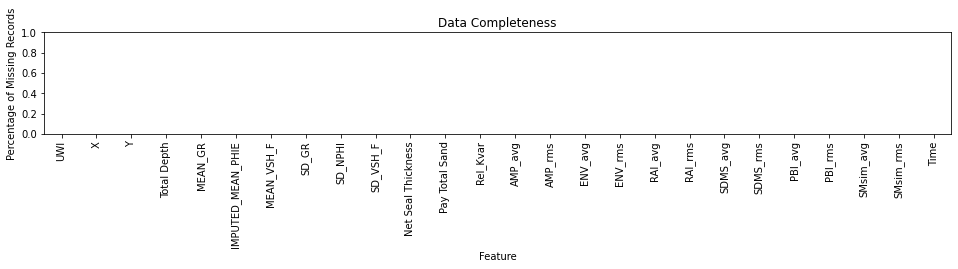

In [5]:
plt.subplot(311)
(df.isnull().sum()/len(df)).plot(kind = 'bar')        # calculate DataFrame with percentage missing by feature
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.1, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Visualize Data Coverage

Proportion missing is useful, but does not allow us to see relationships between features and samples of missing sample values. 

* let's make a missing data heat map

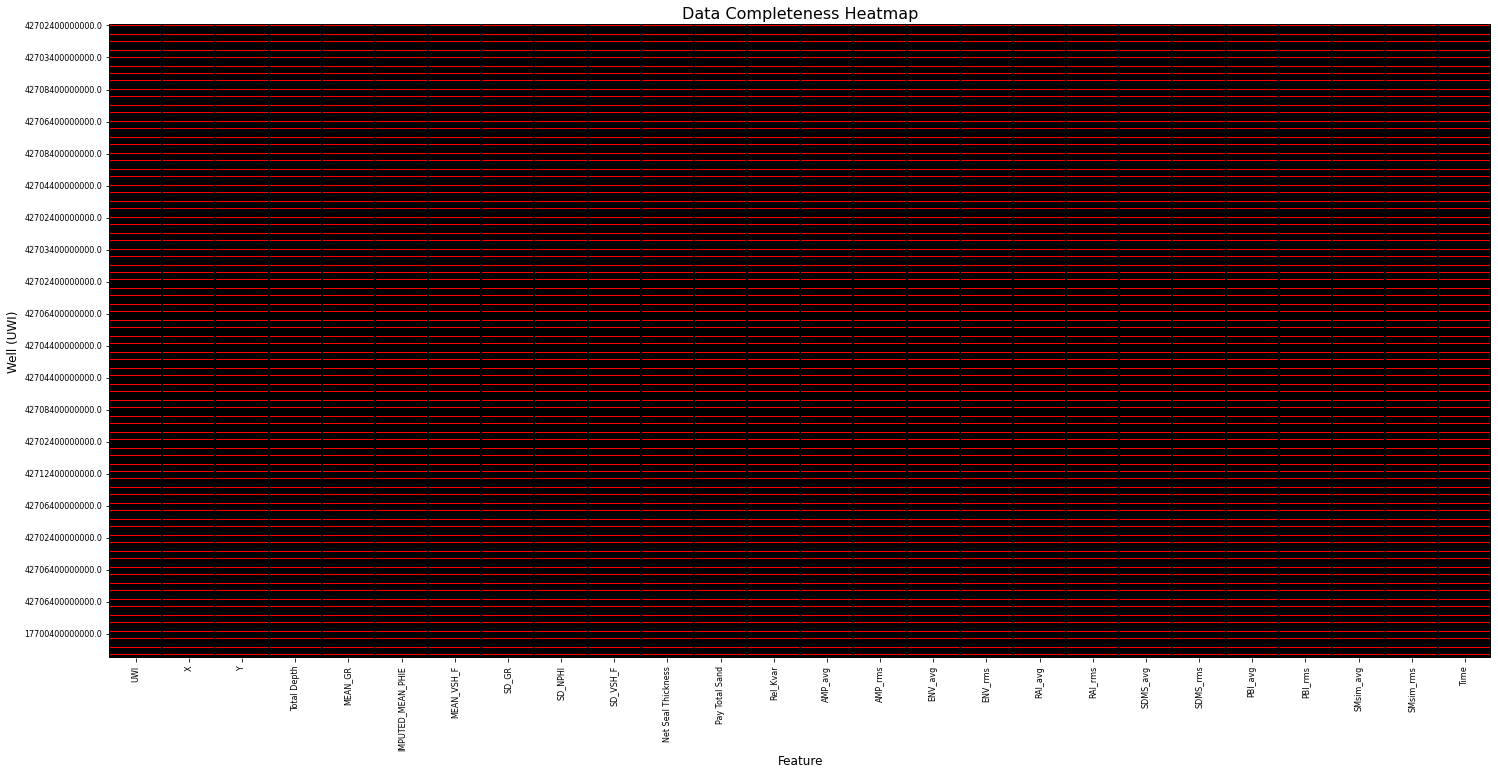

In [6]:
df_temp = df.copy(deep=True)                          # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                            # true is value, false if NaN
df_bool = df_bool.set_index(df_temp.pop('UWI'))       # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.1) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Well (UWI)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2); plt.show()

#### Clean the Data

We do the following data cleaning:

* strip off repeative components of feature labels
* remove features to greater than a threshold missing

In [7]:
missing_threshold = 0.7                               # maximum missing samples by-feature
#df.columns = df.columns.str.rstrip('3_9_22')          # clean up feature names

print('Initial features: ') 
print(df.columns)
df_nonull = df.copy(deep = True)                      # deep copy of the data
print('Number of wells = ' + str(len(df_nonull)) + '.')                                 # check number of samples 

print('Number of initial features: ' + str(len(df.columns)))
#df_nonull = df_nonull.loc[:, df_nonull.isnull().mean() < missing_threshold] # drop columns with >= 70% missing
print('Number of final features: ' + str(len(df_nonull.columns)))

Initial features: 
Index(['UWI', 'X', 'Y', 'Total Depth', 'MEAN_GR', 'IMPUTED_MEAN_PHIE',
       'MEAN_VSH_F', 'SD_GR', 'SD_NPHI', 'SD_VSH_F', 'Net Seal Thickness',
       'Pay Total Sand', 'Rel_Kvar', 'AMP_avg', 'AMP_rms', 'ENV_avg',
       'ENV_rms', 'RAI_avg', 'RAI_rms', 'SDMS_avg', 'SDMS_rms', 'PBI_avg',
       'PBI_rms', 'SMsim_avg', 'SMsim_rms', 'Time'],
      dtype='object')
Number of wells = 277.
Number of initial features: 26
Number of final features: 26


#### Check Data Completeness

Bar chart of proportion missing samples by-feature

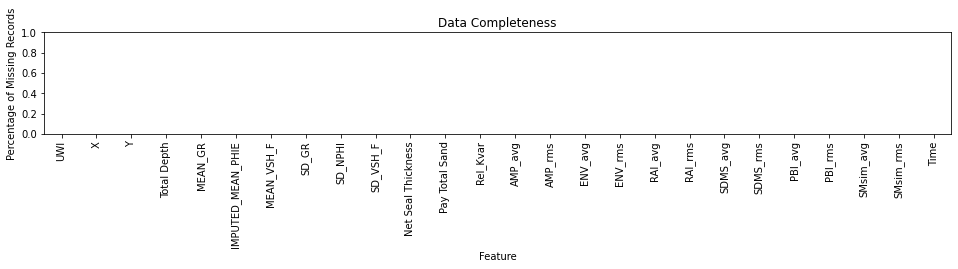

In [8]:
plt.subplot(311)
(df_nonull.isnull().sum()/len(df_nonull)).plot(kind = 'bar') # calculate DataFrame with percentage missing by feature
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.1, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Eliminate All Missing Data

Currently we use likewise deletion to remove all samples with any missing feature values.

* In the future this could be replaced by feature imputation

Then confirm that we have perfect coverage.

Number of records = 277
Number of features = 26


(0.0, 1.0)

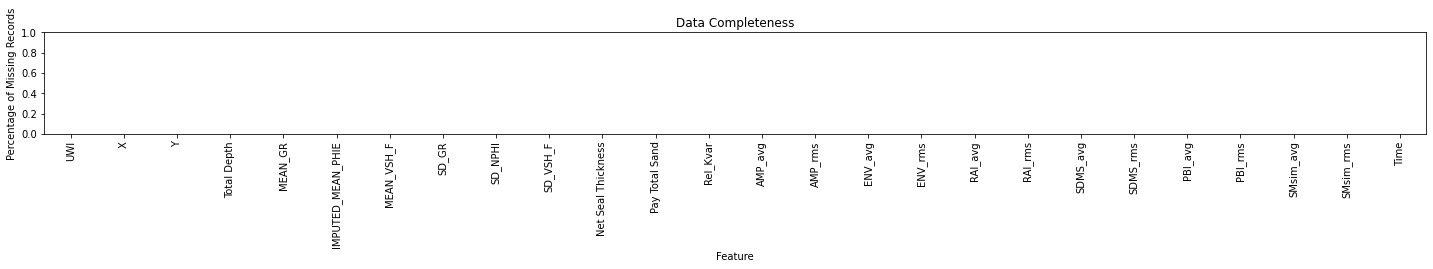

In [9]:
df_nonull.dropna(axis=0,how='any',inplace=True)       # likewise deletion

print('Number of records = ' + str(len(df_nonull)))
print('Number of features = ' + str(len(df_nonull.columns)))

plt.subplot(312)                                      # data completeness bar chart
(df_nonull.isnull().sum()/len(df_nonull)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])

In [10]:
# print('Number of records = ' + str(len(df_well_sub)) + '.')

# df_well_sub.head()

# icols_loc = np.r_[12:16]; floc = df_well_sub.columns[icols_loc].to_list()
# icols_f = np.r_[4:10]; f = df_well_sub.columns[icols_f].to_list()

# print('Location features = ' + str(floc) + '.')
# print('Features = ' + str(f) + '.')

# lmin = [83875.0,2985926.0,3000]; lmax = [1010000.0,3300500.0,8000.0]; lunit = ['meters','meters','meters']
# print('X extent = ' + str(lmax[0]-lmin[0]) + ', Y extent = ' + str(lmax[1]-lmin[1]) + ', Depth extent = ' + str(lmax[2]-lmin[2]))
# print('X:Y Extent Ratio = ' + str( (lmax[0]-lmin[0])/(lmax[1]-lmin[1]) ) + '.')

# fmin = [0.0,-0.1,0.09,0.0,0.0,0.0]; fmax = [200.0,1.05,100.0,0.47,1400.0,800.0]; funit = ['API','%','API','%','meters','meters']
# fname = ['Average Gamma Ray','Average Fraction Shale','Standard Deviation of Gamma Ray','Standard Deviation of Fraction of Shale','Net Seal Thickness','Total Pay Thickness']


#### Formulate the Predictor Feature and Response Feature DataFrames

In [10]:
response = 'Pay Total Sand'; response2 = 'IMPUTED_MEAN_PHIE'
ix = np.r_[13:25]; x = df_nonull.iloc[:,ix].copy(deep = True) 
y = pd.DataFrame({response:df_nonull[response]}); y2 = pd.DataFrame({response2:df_nonull[response2]})  
features = x.columns
x.head()

,AMP_avg,AMP_rms,ENV_avg,ENV_rms,RAI_avg,RAI_rms,SDMS_avg,SDMS_rms,PBI_avg,PBI_rms,SMsim_avg,SMsim_rms
0,0.001247,0.200347,0.620927,0.692911,0.031266,0.801342,2.395739,3.320373,2.942757,4.671981,0.922386,0.923909
1,-0.001618,0.286621,0.808946,0.955027,0.062995,1.238200,0.368944,0.950030,1.032320,1.594880,0.961676,0.961944
2,-0.003547,0.146222,0.387977,0.443267,0.063275,0.740130,1.402810,2.697880,3.469650,4.167890,0.883054,0.883719
3,-0.000958,0.160091,0.419338,0.487525,0.017342,0.651137,5.279798,6.641667,2.942992,4.596672,0.898774,0.900020
4,-0.000816,0.270008,0.883893,1.021655,0.047766,1.314789,2.489978,3.944521,2.339259,4.507995,0.929366,0.930132


#### Predictor Feature Statistics

In [11]:
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AMP_avg,277.0,0.000787,0.004003,-0.009582,-0.001807,0.000411,0.002617,0.014462
AMP_rms,277.0,0.252158,0.074658,0.055386,0.204550,0.249639,0.305146,0.498032
ENV_avg,277.0,0.783168,0.231310,0.166379,0.646280,0.778410,0.928684,1.539090
ENV_rms,277.0,0.894378,0.263421,0.190860,0.729959,0.878774,1.082030,1.702560
RAI_avg,277.0,0.035965,0.026656,-0.006564,0.018682,0.029020,0.045892,0.175012
RAI_rms,277.0,1.299834,0.372791,0.235139,1.013283,1.291535,1.581329,2.470470
SDMS_avg,277.0,2.697399,2.592754,0.031870,1.243065,1.940989,3.234713,20.235300
SDMS_rms,277.0,3.798315,2.774253,0.393096,2.116579,2.976224,4.505725,21.061100
PBI_avg,277.0,2.495695,1.756637,0.439705,1.448160,2.081760,2.942992,14.608600
PBI_rms,277.0,3.851877,2.716594,0.575992,2.026320,3.441580,4.896831,22.461400


#### Describe the Features

In [12]:
funit = ['','','','','','','','','','','','']
features = ['AMP_avg','AMP_rms','ENV_avg','ENV_rms','RAI_avg','RAI_rms',
      'SDMS_avg','SDMS_rms','PBI_avg','PBI_rms','SMsim_avg','SMsim_rms']
fname = ['Amplitude Avg','Amplitude RMS','Envelope Avg','Envelope RMS',
          'Relative Acoustic Impedance Avg','Relative Acoustic Impedance RMS',
          'Smooth Dip of Max. Similarity Avg','Smooth Dip of Max. Similarity RMS',
          'Parallel Bed Indicator Avg','Parallel Bed Indicator RMS',
          'Smooth Similarity Avg','Smooth Similarity RMS']
ffile = ['Seismic/6542a 6543 amp avg.dat','Seismic/6542a 6543 amp rms.dat',
          'Seismic/6542a 6543 Env avg.dat','Seismic/6542a 6543 Env rms.dat',
          'Seismic/6542a 6543 rai avg.dat','Seismic/6542a 6543 rai rms.dat',
          'Seismic/6542a 6543 sdms avg.dat','Seismic/6542a 6543 sdms rms.dat',
          'Seismic/6542a 6543 PBI avg.dat','Seismic/6542a 6543 PBI rms.dat',
          'Seismic/6542a 6543 SMsim avg.dat','Seismic/6542a 6543 SMsim rms.dat']

fmin = x[features].min().values; 
fmin = np.full(len(features),0.0); fmin[0] = -0.03 # negative amplitude
#sfmax = df_seis[sf].max().values; 
fmax = [0.03,0.75,2.5,2.5,0.25,4.0,35,50.0,50.0,60.0,1.0,1.0]

#### Check Feature Histograms

Now let's check the feature histograms.

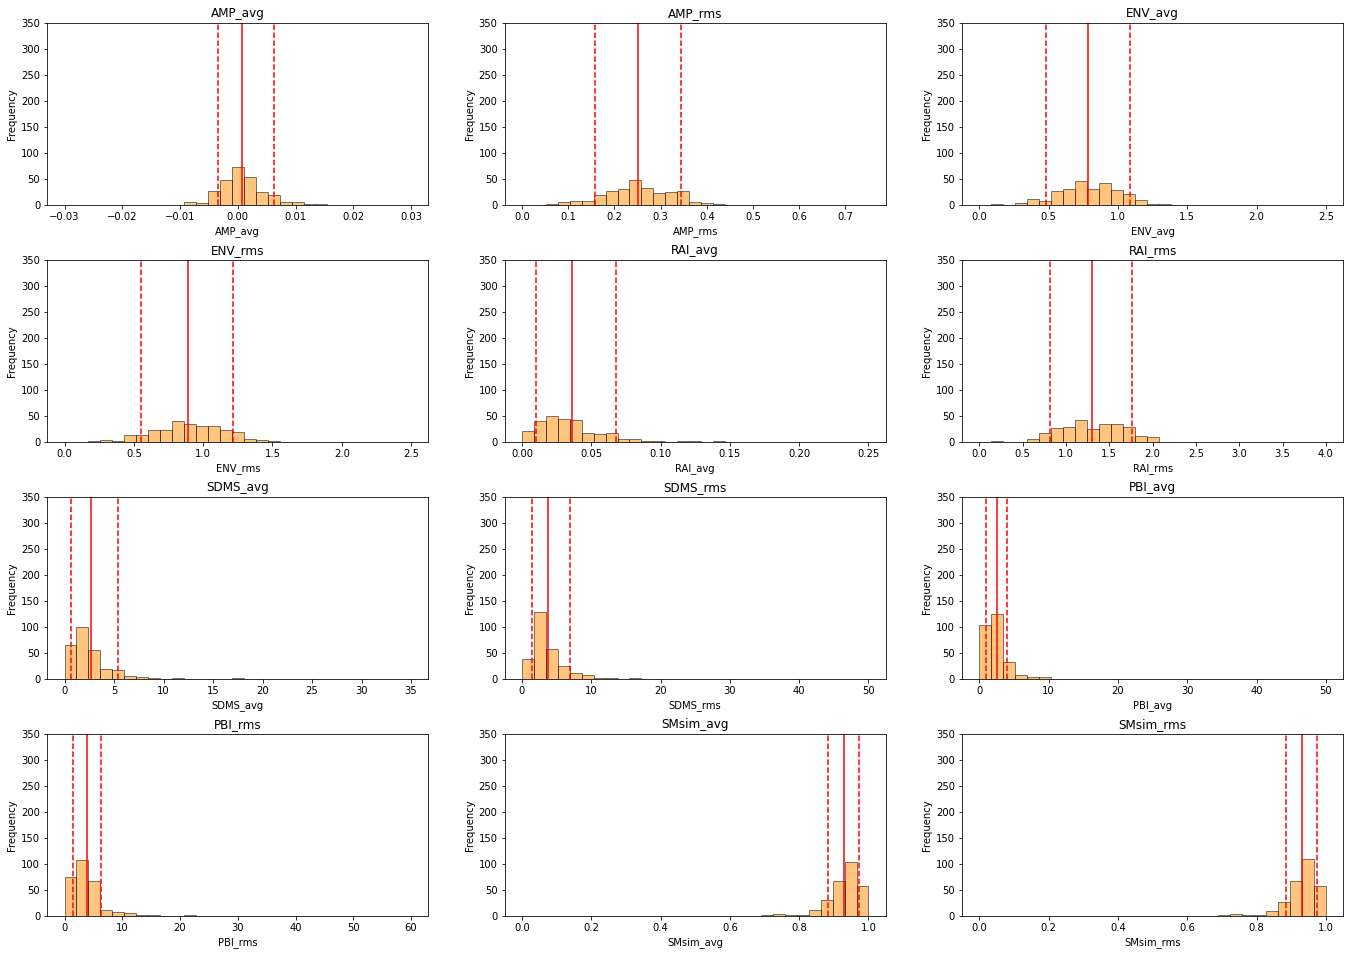

In [13]:
nbins = 30                                            # number of histogram bins

for i, feature in enumerate(features):                # plot histograms with central tendancy and P10 and P90 labelled
    plt.subplot(round(len(features)/3+0.5),3,i+1)
    hist = plt.hist(x=df_nonull[feature],weights=None,bins=np.linspace(fmin[i],fmax[i],nbins),alpha = 0.5,edgecolor='black',color='darkorange')
    histogram_bounds(values=df_nonull[feature].values,weights=np.ones(len(df_nonull)),color='red',ymax=350)
    plt.xlabel(feature); plt.ylim([0,350])
    plt.ylabel('Frequency')
    plt.title(feature)                     

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=3.1, wspace=0.2, hspace=0.3)
plt.show()

#### Plot the Response Distribution to Assign Thresholds

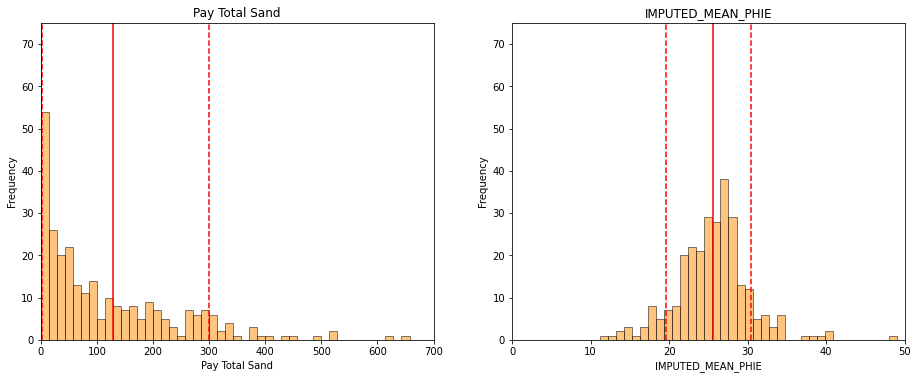

In [165]:
plt.subplot(121)
hist = plt.hist(x=df_nonull[response],weights=None,bins=np.linspace(0,700,50),alpha = 0.5,edgecolor='black',color='darkorange')
histogram_bounds(values=df_nonull[response].values,weights=np.ones(len(df_nonull)),color='red',ymax=200)
plt.xlabel(response); plt.xlim([0,700])
plt.ylabel('Frequency'); plt.ylim([0,75])
plt.title(response)

plt.subplot(122)
hist2 = plt.hist(x=df_nonull[response2],weights=None,bins=np.linspace(0,50,50),alpha = 0.5,edgecolor='black',color='darkorange')
histogram_bounds(values=df_nonull[response2].values,weights=np.ones(len(df_nonull)),color='red',ymax=200)
plt.xlabel(response2); plt.xlim([0,50])
plt.ylabel('Frequency'); plt.ylim([0,75])
plt.title(response2)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.1, wspace=0.2, hspace=0.3); plt.show()

#### Check Feature Matrix Scatter Plots

We bin the data by the resposne feature and plot the matrix scatter plot with kernel density estimated bivariate PDFs.

* important to check for linearity required by correlation coefficient and partial correlation coefficient
* check for outliers that may impact correlation and models

In [21]:
# df_nonull['c'+response] = pd.cut(x=df[response], bins=[0, 80, 200, 700],
#                      labels=['Low', 'Mid', 'High'])

# nsample = len(df_nonull)

# dpalette = sns.color_palette("rocket_r",n_colors = 3)
# palette = sns.color_palette("rocket")
# matrixplot = sns.pairplot(df_nonull.sample(n=nsample),vars=features,hue ='c'+response,diag_kind = 'kde',palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.2))
# matrixplot.map_lower(sns.kdeplot, levels=3, color="black")
# #plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.2, hspace=0.3)
# plt.show()

#### Voilin Plot 

Difference in conditional distributions.

Update with V clay? Need calculations. To revisit

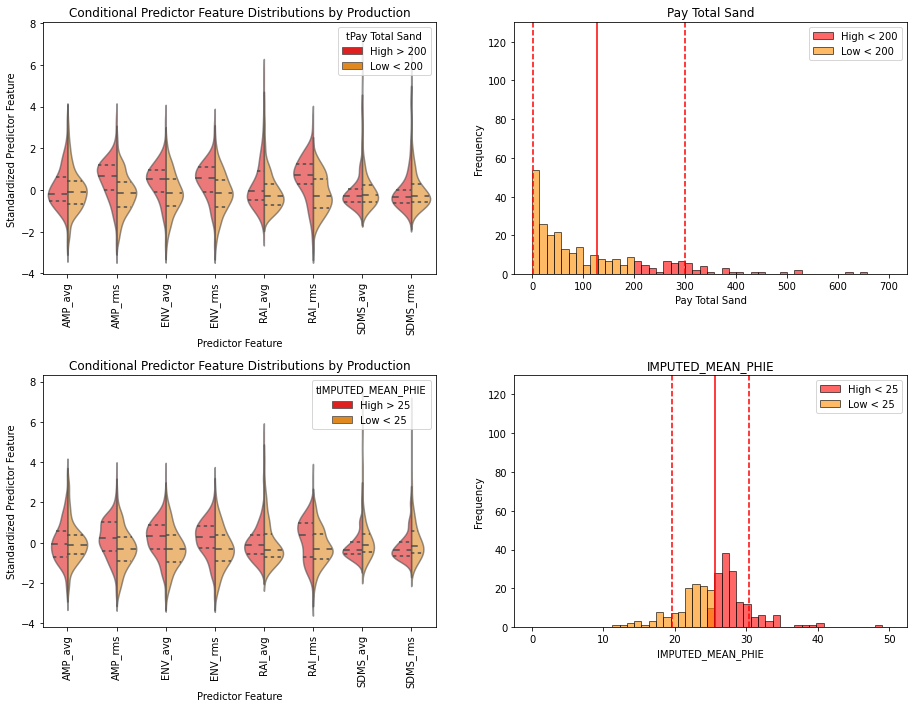

In [28]:
thresh = 200
thresh2 = 25
df['t'+response] = np.where(df[response]>=thresh, 'High > ' + str(thresh)  , 'Low < ' +str(thresh)) # make a high and low production categorical feature
df['t'+response2] = np.where(df[response2]>=thresh2, 'High > ' + str(thresh2)  , 'Low < ' +str(thresh2)) # make a high and low production categorical feature

x_temp = x.copy(deep = True)
x_temp_stand = (x_temp - x_temp.mean()) / (x_temp.std())                    # standardization by feature
x_temp = pd.concat([df['t'+response],x_temp_stand.iloc[:,0:8]],axis=1) # add the production categorical feature to the DataFrame
x_temp = pd.melt(x_temp,id_vars='t'+response,var_name="Predictor Feature",value_name='Standardized Predictor Feature') # unpivot the DataFrame

plt.subplot(221)
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue='t'+response, data=x_temp,split=True, inner="quart", palette=['red','darkorange'],alpha=0.6)
plt.xticks(rotation=90); plt.title('Conditional Predictor Feature Distributions by Production')
ax = plt.gca()
plt.setp(ax.collections, alpha=.6)

plt.subplot(222)
hist = plt.hist(x=df_nonull[df_nonull[response] >= thresh][response].values,weights=None,bins=np.linspace(0,700,50),alpha = 0.6,edgecolor='black',color='red',label='High < ' +str(thresh))
hist = plt.hist(x=df_nonull[df_nonull[response] < thresh][response].values,weights=None,bins=np.linspace(0,700,50),alpha = 0.6,edgecolor='black',color='darkorange',label = 'Low < ' +str(thresh))
histogram_bounds(values=df_nonull[response].values,weights=np.ones(len(df_nonull)),color='red',ymax=130)
plt.xlabel(response); 
plt.ylabel('Frequency'); plt.ylim([0,130])
plt.title(response); plt.legend(loc = 'upper right')

x_temp2 = x.copy(deep = True)
x_temp2_stand = (x_temp2 - x_temp2.mean()) / (x_temp2.std())                    # standardization by feature
x_temp2 = pd.concat([df['t'+response2],x_temp2_stand.iloc[:,0:8]],axis=1) # add the production categorical feature to the DataFrame
x_temp2 = pd.melt(x_temp2,id_vars='t'+response2,var_name="Predictor Feature",value_name='Standardized Predictor Feature') # unpivot the DataFrame

plt.subplot(223)
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue='t'+response2, data=x_temp2,split=True, inner="quart", palette=['red','darkorange'],alpha=0.6)
plt.xticks(rotation=90); plt.title('Conditional Predictor Feature Distributions by Production')
ax = plt.gca()
plt.setp(ax.collections, alpha=.6)

plt.subplot(224)
hist2 = plt.hist(x=df_nonull[df_nonull[response2] >= thresh2][response2].values,weights=None,bins=np.linspace(0,50,50),alpha = 0.6,edgecolor='black',color='red',label='High < ' +str(thresh2))
hist2 = plt.hist(x=df_nonull[df_nonull[response2] < thresh2][response2].values,weights=None,bins=np.linspace(0,50,50),alpha = 0.6,edgecolor='black',color='darkorange',label = 'Low < ' +str(thresh2))
histogram_bounds(values=df_nonull[response2].values,weights=np.ones(len(df_nonull)),color='red',ymax=130)
plt.xlabel(response2); 
plt.ylabel('Frequency'); plt.ylim([0,130])
plt.title(response2); plt.legend(loc = 'upper right')

#****Cut the middle out, highlight lower and higher percentiles - Tails matter! Spatially map the tails, P05, P95.

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.4); plt.show()

#### Apply Univariate Gaussian Transform

In [29]:
dfS = pd.DataFrame()                      # Gaussian transformation of each feature 
dfS['UWI'] = df_nonull['UWI'].values
ddfS = dfS.reset_index()
for col in x.columns.tolist():
    print(col)
    dfS['N' + col] = geostats.nscore(df_nonull,col)[0]
    #dfS['test'] = 1
#dfS['c'+response] = df_nonull['c'+response].values
dfS.head()

AMP_avg
AMP_rms
ENV_avg
ENV_rms
RAI_avg
RAI_rms
SDMS_avg
SDMS_rms
PBI_avg
PBI_rms
SMsim_avg
SMsim_rms


,UWI,NAMP_avg,NAMP_rms,NENV_avg,NENV_rms,NRAI_avg,NRAI_rms,NSDMS_avg,NSDMS_rms,NPBI_avg,NPBI_rms,NSMsim_avg,NSMsim_rms
0,4.270240e+13,0.246811,-0.694507,-0.706070,-0.765383,0.063387,-1.328189,0.228195,0.127030,0.660356,0.572790,-0.370257,-0.409312
1,4.270240e+13,-0.615982,0.499640,0.117912,0.200416,1.101318,-0.090616,-1.589652,-2.056741,-1.170307,-1.052830,0.717729,0.717729
2,4.271240e+13,-1.306638,-1.421282,-1.657230,-1.657230,1.118068,-1.622515,-0.479239,-0.209657,0.948332,0.429073,-1.245368,-1.306638
3,4.270340e+13,-0.469113,-1.225952,-1.528640,-1.446581,-0.741346,-1.821097,1.188448,1.152544,0.671652,0.551593,-0.893030,-0.948332
4,4.270840e+13,-0.409312,0.237493,0.389710,0.429073,0.741346,0.036205,0.256151,0.509919,0.154448,0.520252,-0.256151,-0.274899


#### Recheck Feature Matrix Scatter Plots

Check for Gaussianity of bivariate distributions after Gaussian transform.

* Will add more quantitative methods

In [30]:
# nfeatures = dfS.columns[1:len(dfS.columns)-1]
# matrixplot = sns.pairplot(dfS.sample(n=nsample),vars=nfeatures,diag_kind = 'kde',palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.2))
# matrixplot.map_lower(sns.kdeplot, levels=3, color="black")
# #plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.2, hspace=0.3)
# plt.show()

#### Henze-Zirkler Test for Multivariate Gaussianity

Let's apply the Henze-Zirkler test for multivariate normality in a pairwise manner.

* The result is a matrix of probability values, if less than alpha we reject the null hypothesis, $h_0$: bivariate normality after the univerate Gaussian transform

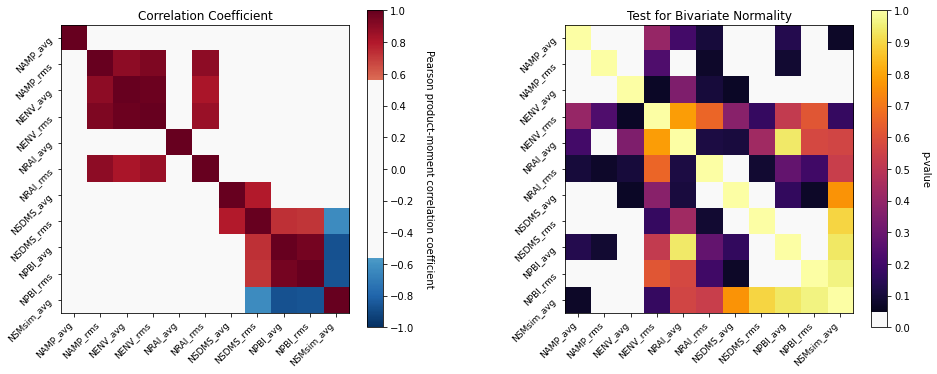

In [31]:
cols = dfS.iloc[:,1:len(dfS.columns)-1].columns
ncols = len(cols)

pmatrix = np.zeros([len(dfS.columns)-2,len(dfS.columns)-2])
for m, mcol in enumerate(dfS.columns[1:len(dfS.columns)-1]):
    for n, ncol in enumerate(dfS.columns[1:len(dfS.columns)-1]):
        x_temp = np.concatenate((dfS[mcol].values,dfS[ncol].values))
        p = multivariate_normality(np.vstack((dfS[mcol].values,dfS[ncol].values)).T)[1] 
        pmatrix[m-1,n-1] = p
        
for m, mcol in enumerate(dfS.columns[1:len(dfS.columns)-1]):
    pmatrix[m,m] = 1.0 
        
plt.subplot(121)
im1 = plt.imshow(dfS.iloc[:,1:len(dfS.columns)-1].corr().values,interpolation = None,extent = [ncols,0,0,ncols], vmin = -1, vmax = 1,cmap = signif)
cbar = plt.colorbar(im1, orientation="vertical", ticks=np.linspace(-1, 1, 11))
cbar.set_label('Pearson product-moment correlation coefficient', rotation=270, labelpad=20)
plt.xticks(np.arange(ncols-0.5,-0.5,-1.0), cols, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.yticks(np.arange(ncols-0.5,-0.5,-1.0), cols, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.title("Correlation Coefficient")


plt.subplot(122)
im2 = plt.imshow(pmatrix,interpolation = None,extent = [ncols,0,0,ncols], vmin = 0, vmax = 1,cmap = sign1)
cbar = plt.colorbar(im2, orientation="vertical", ticks=np.linspace(0, 1, 11))
cbar.set_label('p-value', rotation=270, labelpad=20)
plt.xticks(np.arange(ncols-0.5,-0.5,-1.0), cols, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.yticks(np.arange(ncols-0.5,-0.5,-1.0), cols, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.title("Test for Bivariate Normality")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.1, wspace=0.4, hspace=0.3)
plt.show()

#### Conditional Distributions / Trend Analysis

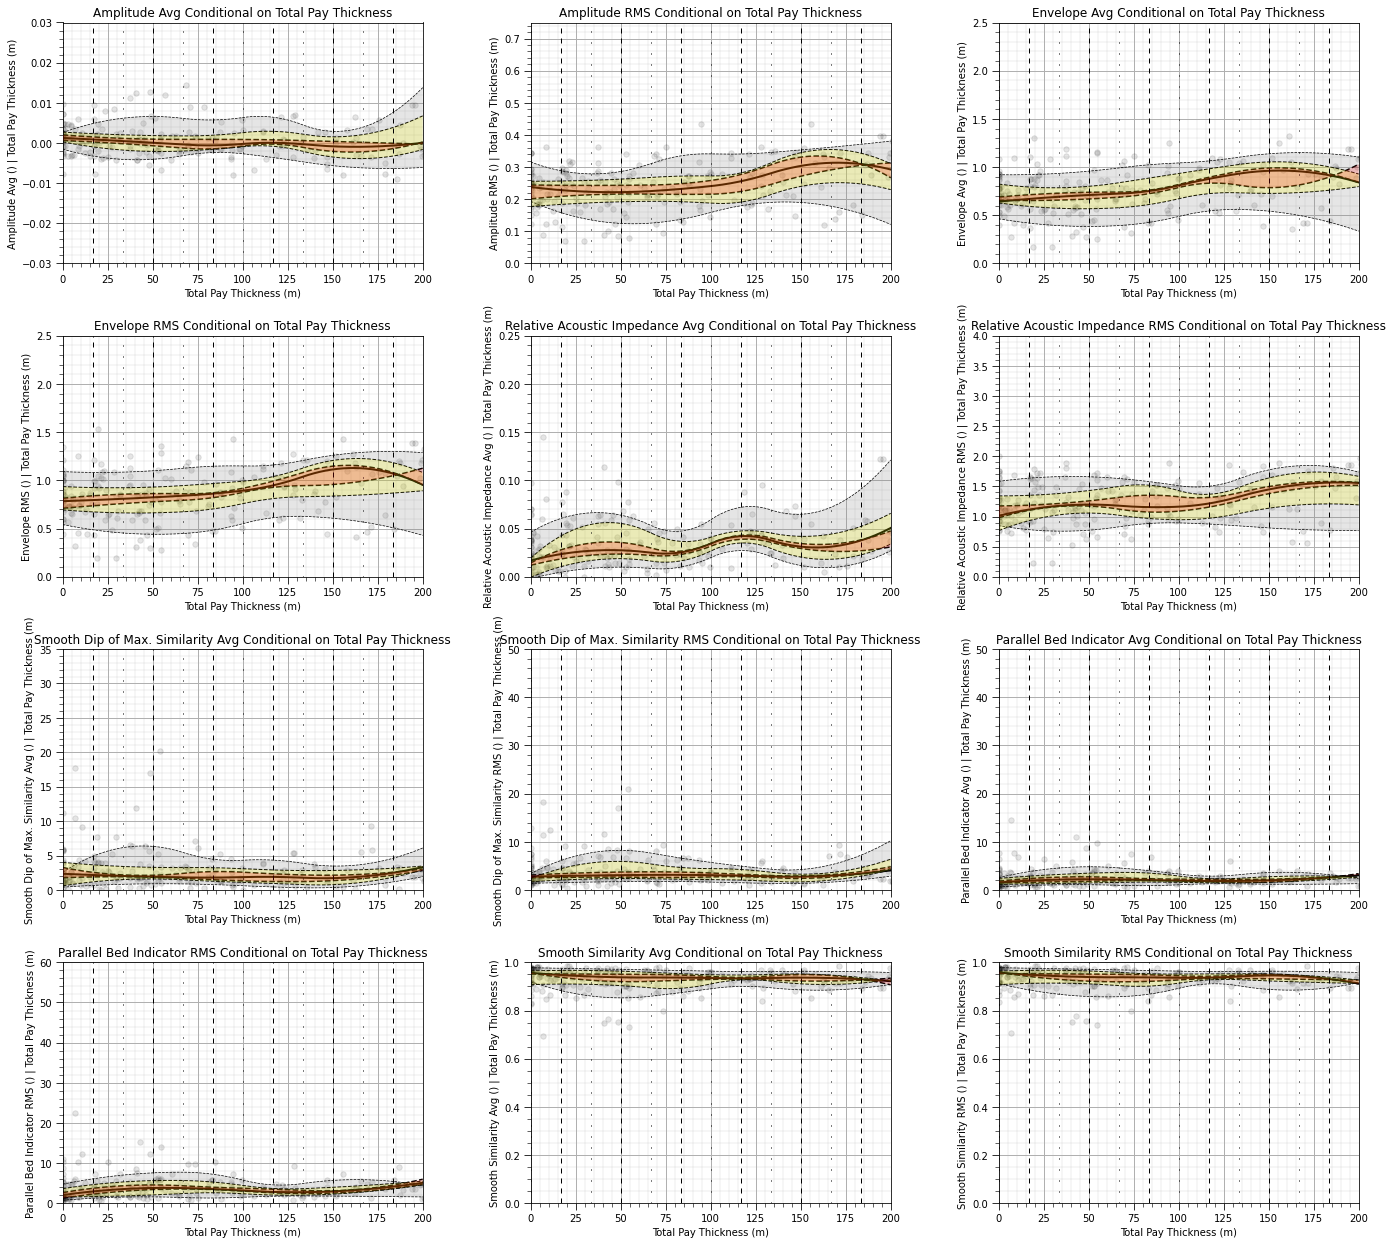

In [32]:
from scipy.interpolate import make_interp_spline, BSpline

Well_P50splines = []; Well_P10splines = []; Well_P90splines = []

for i, feature in enumerate(features):
    plt.subplot(round(len(features)/3+0.5),3,i+1)
    P50spline, P10spline, P90spline = cond_prob_plot(y[response].values,0,200,'Total Pay Thickness','m',6,
                                                     x[features[i]],fmin[i],fmax[i],fname[i],funit[i])
    Well_P50splines.append(P50spline); Well_P10splines.append(P10spline); Well_P90splines.append(P90spline)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=round(len(features)/3+0.5)+0.1, wspace=0.3, hspace=0.3)
plt.show()

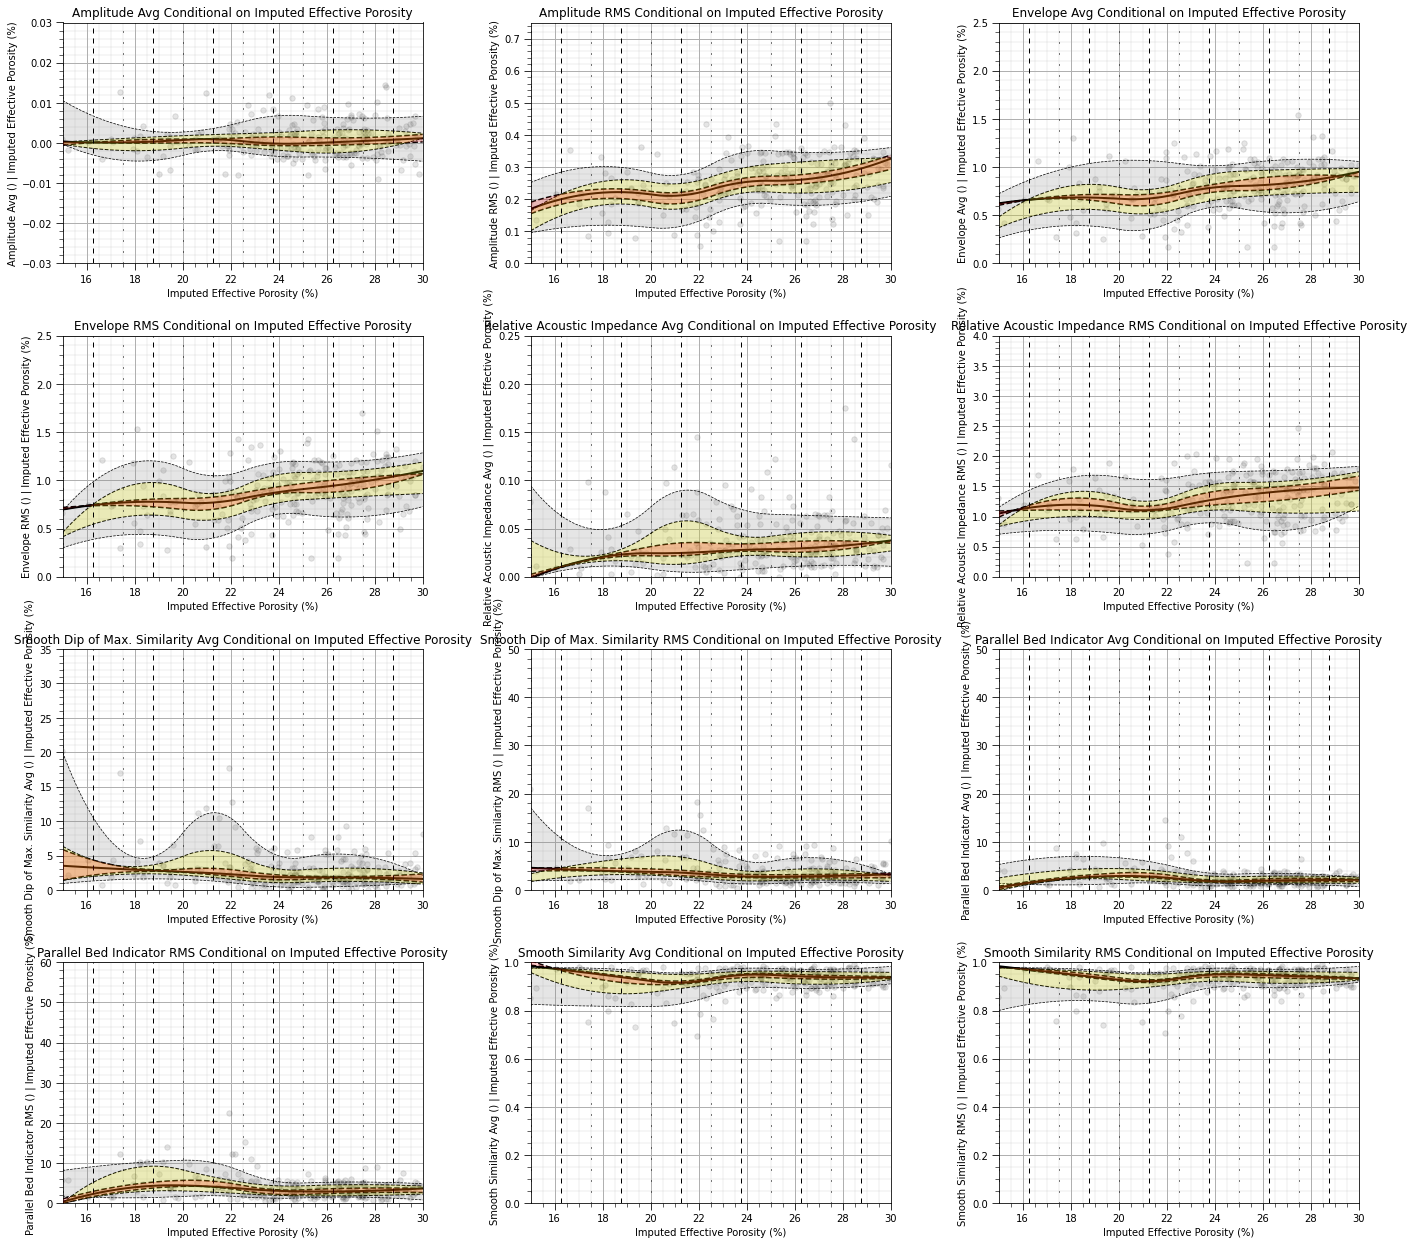

In [39]:
Well_P50splines = []; Well_P10splines = []; Well_P90splines = []

for i, feature in enumerate(features):
    plt.subplot(round(len(features)/3+0.5),3,i+1)
    P50spline, P10spline, P90spline = cond_prob_plot(y2[response2].values,15,30,'Imputed Effective Porosity','%',6,
                                                     x[features[i]],fmin[i],fmax[i],fname[i],funit[i])
    Well_P50splines.append(P50spline); Well_P10splines.append(P10spline); Well_P90splines.append(P90spline)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=round(len(features)/3+0.5)+0.1, wspace=0.3, hspace=0.3)
plt.show()

#### Variance Inflation Factor (VIF)

A measure of linear multicolinearity between a predictor feature ($X_i$) a nd all other predictor features ($X_j, \forall j \ne i$).

First we calculate a linear regression for a predictor feature given all the other predictor features.

\begin{equation}
X_i = \sum_{j, j \ne i}^m X_j + \epsilon
\end{equation}

From this model we determine the coefficient of determination, $R^2$, known as variance explained.

Then we calculate the Variance Inflation Factor as:

\begin{equation}
VIF = \frac{1}{1 - R^2}
\end{equation}

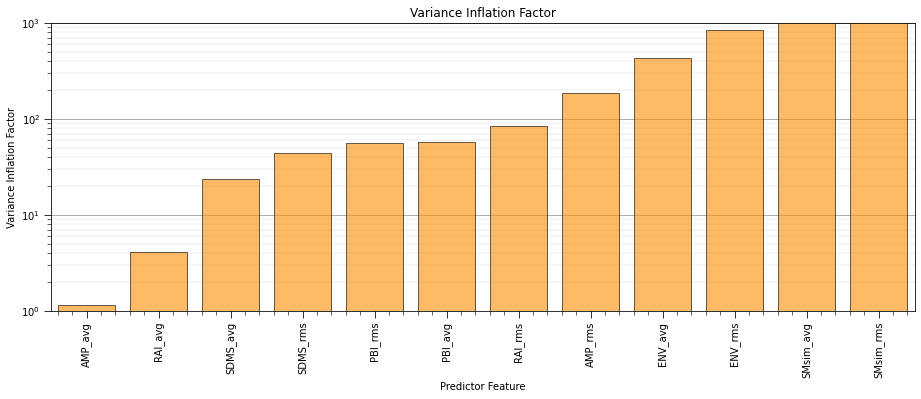

In [40]:
vif_values = []
for i in range(x.shape[1]):
    vif_values.append(variance_inflation_factor(x.values, i))

vif_values = np.asarray(vif_values)
indices = np.argsort(vif_values)[::1]           # find indicies for descending order

plt.subplot(111)                                      # plot the feature importance 
plt.title("Variance Inflation Factor")
plt.bar(range(x.shape[1]), vif_values[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6, align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90); 

#plt.grid(axis = 'y',which = 'both')

plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

plt.xlim([-0.5, x.shape[1]-0.5]); plt.yscale('log'); plt.ylim([1.0,1.0e3])
plt.xlabel('Predictor Feature'); plt.ylabel('Variance Inflation Factor')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()


#### Model-based Feature Importance

Let's start with a typical feature ranking method, feature importance from [random forest](https://www.youtube.com/watch?v=m5_wk310fho&list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&index=39) predictive machine learning.

Variance explained of the model: 0.6903310872714006
Variance explained of the model: 0.7400695733756718


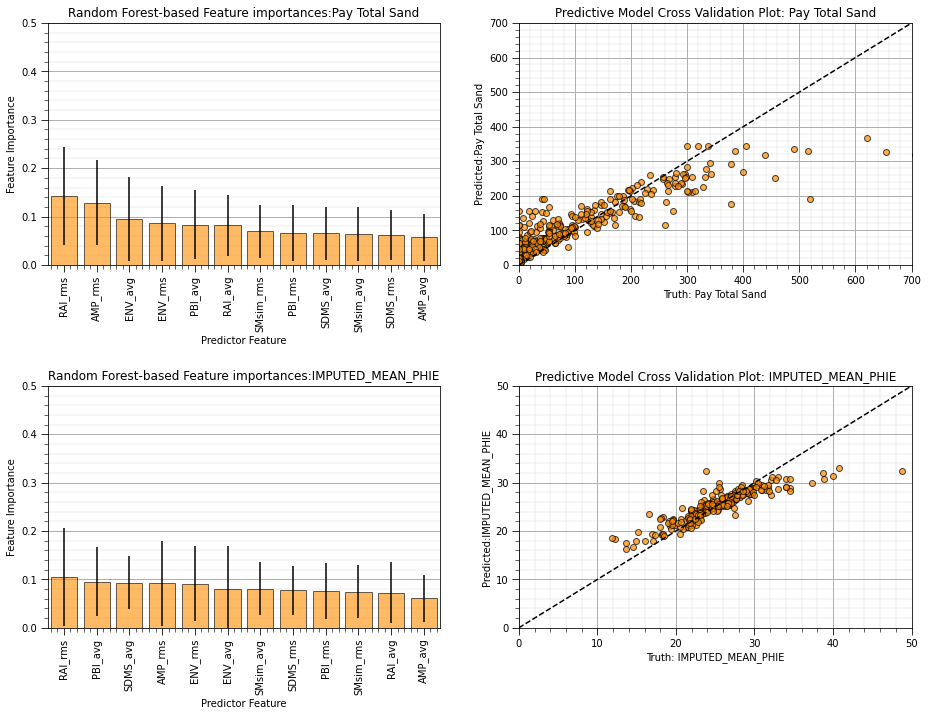

In [50]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

seed = 73093                                                # set the random forest hyperparameters
max_depth = 10
min_samples_leaf = 2
num_tree = 1000
max_features = 4
random_forest = RandomForestRegressor(min_samples_leaf = min_samples_leaf,random_state=seed,n_estimators=num_tree, max_features=max_features)
random_forest.fit(x,y) # fit the random forest
y_hat = random_forest.predict(x)
importance_rank = random_forest.feature_importances_ # extract the expected feature importances
print('Variance explained of the model: ' + str(random_forest.score(x,y)))
importance_rank_stand = importance_rank/np.max(importance_rank)                          # calculate relative mutual information

std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importance_rank)[::-1]           # find indicies for descending order

plt.subplot(221)                                      # plot the feature importance 
plt.title("Random Forest-based Feature importances:" + str(response))
plt.bar(range(x.shape[1]), importance_rank[indices],edgecolor = 'black',
       color="darkorange",alpha = 0.6, yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.ylim([0.,0.5])
plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplot(222)
plt.scatter(y,y_hat,color='darkorange',edgecolor='black',alpha=0.7)
plt.grid(b=True,which='both',axis='both')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.xlim([0,700]); plt.ylim([0,700]); plt.xlabel('Truth: ' + response); plt.ylabel('Predicted:' + response)
plt.plot([0,700],[0,700],color='black',ls='--'); plt.title('Predictive Model Cross Validation Plot: ' + response)

random_forest2 = RandomForestRegressor(min_samples_leaf = min_samples_leaf,random_state=seed,n_estimators=num_tree, max_features=max_features)
random_forest2.fit(x,y2) # fit the random forest
y_hat2 = random_forest2.predict(x)
importance_rank2 = random_forest2.feature_importances_ # extract the expected feature importances
print('Variance explained of the model: ' + str(random_forest2.score(x,y2)))
importance_rank_stand2 = importance_rank2/np.max(importance_rank2)                          # calculate relative mutual information

std2 = np.std([tree.feature_importances_ for tree in random_forest2.estimators_],axis=0) # calculate stdev over trees
indices2 = np.argsort(importance_rank2)[::-1]           # find indicies for descending order

plt.subplot(223)                                      # plot the feature importance 
plt.title("Random Forest-based Feature importances:" + str(response2))
plt.bar(range(x.shape[1]), importance_rank2[indices2],edgecolor = 'black',
       color="darkorange",alpha = 0.6, yerr=std[indices2], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices2],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.ylim([0.,0.5])
plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplot(224)
plt.scatter(y2,y_hat2,color='darkorange',edgecolor='black',alpha=0.7)
plt.grid(b=True,which='both',axis='both')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.xlim([0,50]); plt.ylim([0,50]); plt.xlabel('Truth: ' + response2); plt.ylabel('Predicted:' + response2)
plt.plot([0,50],[0,50],color='black',ls='--'); plt.title('Predictive Model Cross Validation Plot: ' + response2)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.5); plt.show()

#### Mutual Information-based Feature Ranking

Now let's calculate [Mutual Information](https://youtu.be/5Q0gemu-h3Q?t=1352) between the predictors and the response feature.

* a measure of information shared without assumptions, such as linearity and homoscedasticity of correlation coefficients

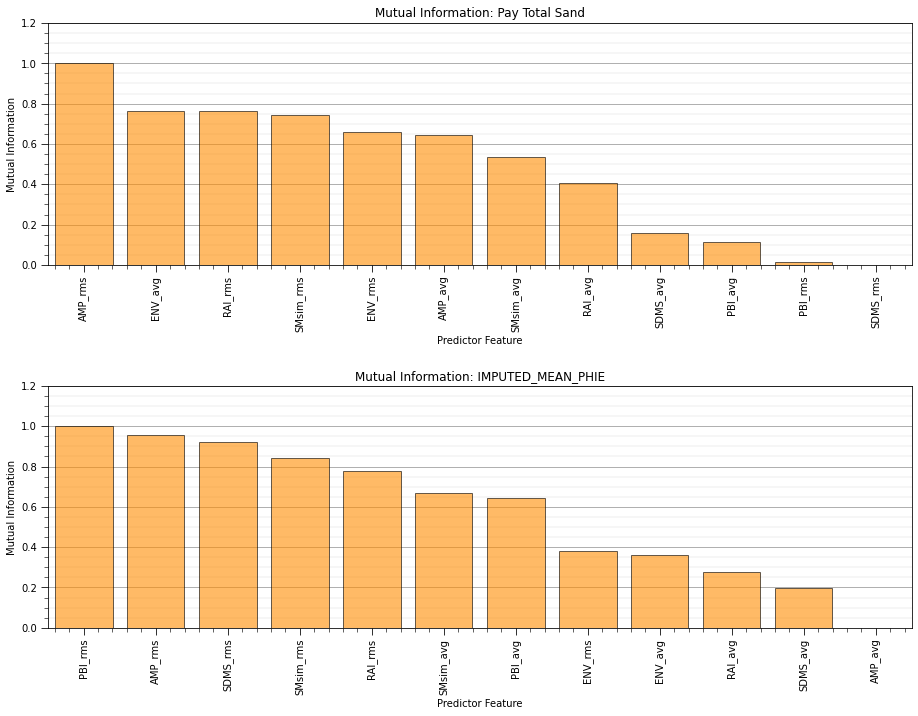

In [60]:
mi = mutual_info_regression(x,y) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

plt.subplot(211)                          # plot the relative mutual information 
plt.title("Mutual Information: " + response)
plt.bar(range(x.shape[1]), mi[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([0,1.2])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Predictor Feature'); plt.ylabel('Mutual Information')

mi2 = mutual_info_regression(x,y2) # calculate mutual information
mi2 /= np.max(mi2)                          # calculate relative mutual information

indices2 = np.argsort(mi2)[::-1]            # find indicies for descending order

plt.subplot(212)                          # plot the relative mutual information 
plt.title("Mutual Information: " + response2)
plt.bar(range(x.shape[1]), mi2[indices2],edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(x.shape[1]), x.columns[indices2],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([0,1.2])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Predictor Feature'); plt.ylabel('Mutual Information')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.5)
plt.show()

#### Mutual Information Accounting For Relevance and Redundancy

The standard Maximum Relevance - Minumum Redundancy (MRMR) objective function considers a subset of predictor features, i.e., to score predictor feature subsets as metric to identify the most informative subset of predictor features.

* the approach calculates the average mutual information between the subset of predictor features and the response feature minus the average mutual information between the subset of predictor features.

\begin{equation}
MID = \frac{1}{|S|}{\sum_{\alpha \in S} I(X_{\alpha},Y) } - \frac{1}{|S|^2} {\sum_{\alpha \in S}^m \sum_{\beta \in S}^m I(X_{\alpha},X_{\beta})}
\end{equation}

as a measure of $relevance - redundancy$ or 

\begin{equation}
MIQ = \frac{ \frac{1}{|S|}{\sum_{\alpha \in S}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha \in S}^m \sum_{\beta \in S}^m I(X_{\alpha},X_{\beta})} }
\end{equation}

* as a measure of $\frac{relevance}{redundancy}$.

I propose that for one-at-a-time predictor feature ranking (predictor feature subset, $S = [X_i]$ and $|S| = 1$) we modify this to the following calculation:

* **relevance** - the mutual information between the selected predictor feature, $X_i$, and the response feature, $Y$
* **redudancy** - the average mutual information between the selected predictor feature, $X_i$, and the remaining predictor features, $X_{\alpha}, \alpha \ne i$.
* we use the quotient form of the calculation from Gulgezen, Cataltepe and Yu (2009).

Our modified version of the Maximum Relevance - Minumum Redundancy (MRMR) objective function for one-at-a-time feature ranking scores the selected predictor feature $X_i$'s **relavance** as its mutual information with the response feature:

\begin{equation}
I(X_i,Y)
\end{equation}

and **redundancy** between the selected predictor feature, $X_i$, and the remaining predictor features:

\begin{equation}
\frac{1}{|S|-1} \sum_{\alpha=1, \alpha \ne i}^m I(X_i,X_{\alpha})
\end{equation}

were $X$ are predictor features, $Y$ is the response feature, $X_i$ is the specific predictor feature being scored and $|S|$ is the number of predictor features and $I()$ is mutual information between the indicated features.

\begin{equation}
\Phi(X_i,Y) = \frac{ I(X_i,Y) }{ \frac{1}{|S|-1} \sum_{\alpha=1, \alpha \ne i}^m I(X_i,X_{\alpha})}
\end{equation}


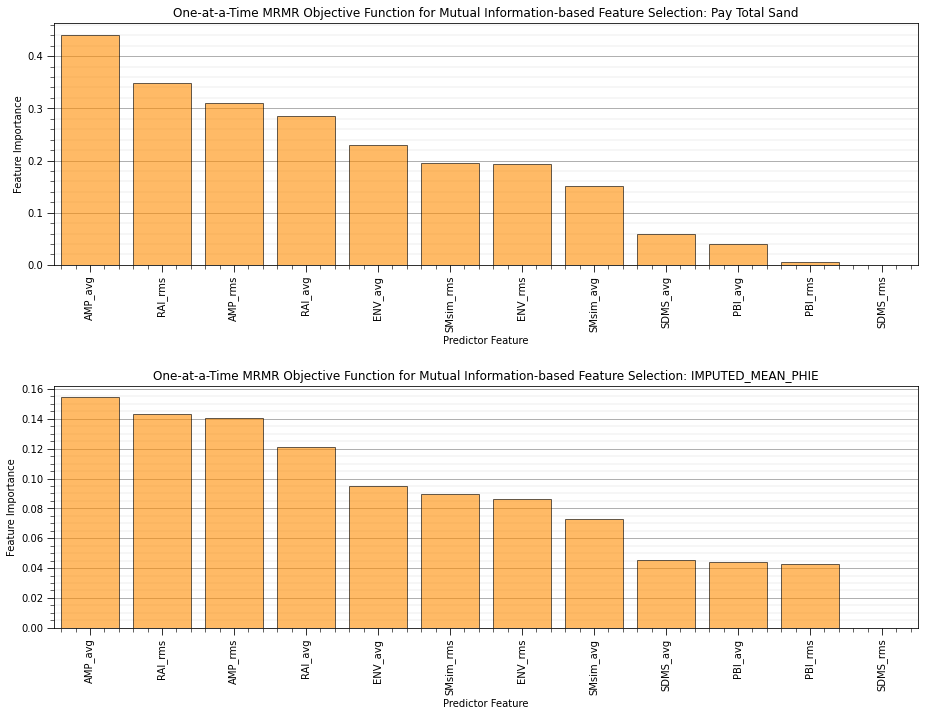

In [56]:
obj_mutual = mutual_information_objective(x,y)
#obj_mutual = (obj_mutual - np.min(obj_mutual))/(np.max(obj_mutual) - np.min(obj_mutual)) # 0 and 1 min / max normalization
indices_obj = np.argsort(obj_mutual)[::-1]            # find indicies for descending order

plt.subplot(211)                          # plot the relative mutual information 
plt.title("One-at-a-Time MRMR Objective Function for Mutual Information-based Feature Selection: " + response)
plt.bar(range(x.shape[1]), obj_mutual[indices_obj],
       color="darkorange",alpha = 0.6, align="center",edgecolor="black")
plt.xticks(range(x.shape[1]), x.columns[indices_obj],rotation=90)
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlim([-0.5, x.shape[1]-0.5]); plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

obj_mutual2 = mutual_information_objective(x,y2)
#obj_mutual = (obj_mutual - np.min(obj_mutual))/(np.max(obj_mutual) - np.min(obj_mutual)) # 0 and 1 min / max normalization
indices_obj2 = np.argsort(obj_mutual2)[::-1]            # find indicies for descending order

plt.subplot(212)                          # plot the relative mutual information 
plt.title("One-at-a-Time MRMR Objective Function for Mutual Information-based Feature Selection: " + response2)
plt.bar(range(x.shape[1]), obj_mutual2[indices_obj2],
       color="darkorange",alpha = 0.6, align="center",edgecolor="black")
plt.xticks(range(x.shape[1]), x.columns[indices_obj],rotation=90)
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlim([-0.5, x.shape[1]-0.5]); plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.5)
plt.show()

#### Delta Mutual Information Quotient Accounting for Relevance and Redundancy

We use the mutual information quotient from Gulgezen, Cataltepe and Yu (2009).

The standard MRMR objective function that scores the subset of features' **relavance** between the subset of predictor features and the response feature:

\begin{equation}
\frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } 
\end{equation}

and **redundancy** between the the subset of predictor features:

\begin{equation}
\frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})}
\end{equation}

To find the most informative subset of predictor features we must find the subset of features that maximize relevance while minimizing redundacy. We can accomplish this by mazimizing either of these two formulations.

\begin{equation}
MID = \frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } - \frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})}
\end{equation}

or 

\begin{equation}
MIQ = \frac{ \frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})} }
\end{equation}

I suggest feature ranking through the calculation of the change in $MIQ$ via inclusion and removal of a specific predictor feature ($X_i$).

\begin{equation}
\Delta MIQ_i = \frac{ \frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})} } - \frac{ \frac{1}{|S|}{\sum_{\alpha=1,\alpha \ne i}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha=1,\alpha \ne i}^m \sum_{\beta=1,\beta \ne i}^m I(X_{\alpha},X_{\beta})} }
\end{equation}

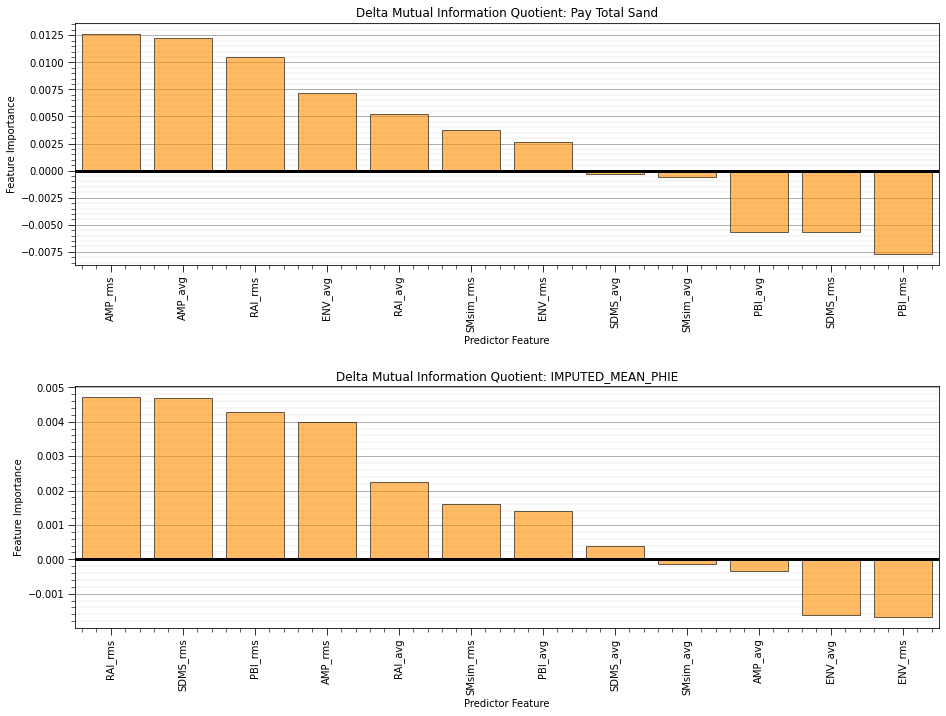

In [57]:
delta_mutual_information = delta_mutual_information_quotient(x,y)

#delta_mutual_information = (delta_mutual_information - np.min(delta_mutual_information))/(np.max(delta_mutual_information) - np.min(obj_mutual))
indices_delta_mutual_information = np.argsort(delta_mutual_information)[::-1]            # find indicies for descending order

plt.subplot(211)                          # plot the relative mutual information 
plt.title("Delta Mutual Information Quotient: " + response)
plt.bar(range(x.shape[1]), delta_mutual_information[indices_delta_mutual_information],
       color="darkorange",alpha = 0.6,align="center",edgecolor = 'black')
plt.xticks(range(x.shape[1]), x.columns[indices_delta_mutual_information],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([-0.5,x.shape[1]-0.5],[0,0],color='black',lw=3); plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

delta_mutual_information2 = delta_mutual_information_quotient(x,y2)

#delta_mutual_information = (delta_mutual_information - np.min(delta_mutual_information))/(np.max(delta_mutual_information) - np.min(obj_mutual))
indices_delta_mutual_information2 = np.argsort(delta_mutual_information2)[::-1]            # find indicies for descending order

plt.subplot(212)                          # plot the relative mutual information 
plt.title("Delta Mutual Information Quotient: " + response2)
plt.bar(range(x.shape[1]), delta_mutual_information2[indices_delta_mutual_information2],
       color="darkorange",alpha = 0.6,align="center",edgecolor = 'black')
plt.xticks(range(x.shape[1]), x.columns[indices_delta_mutual_information2],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([-0.5,x.shape[1]-0.5],[0,0],color='black',lw=3); plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.5)
plt.show()

#### Compare Mutual Information and Random Forest Ranking

Let's compare the ranking by plotting the bar charts together.

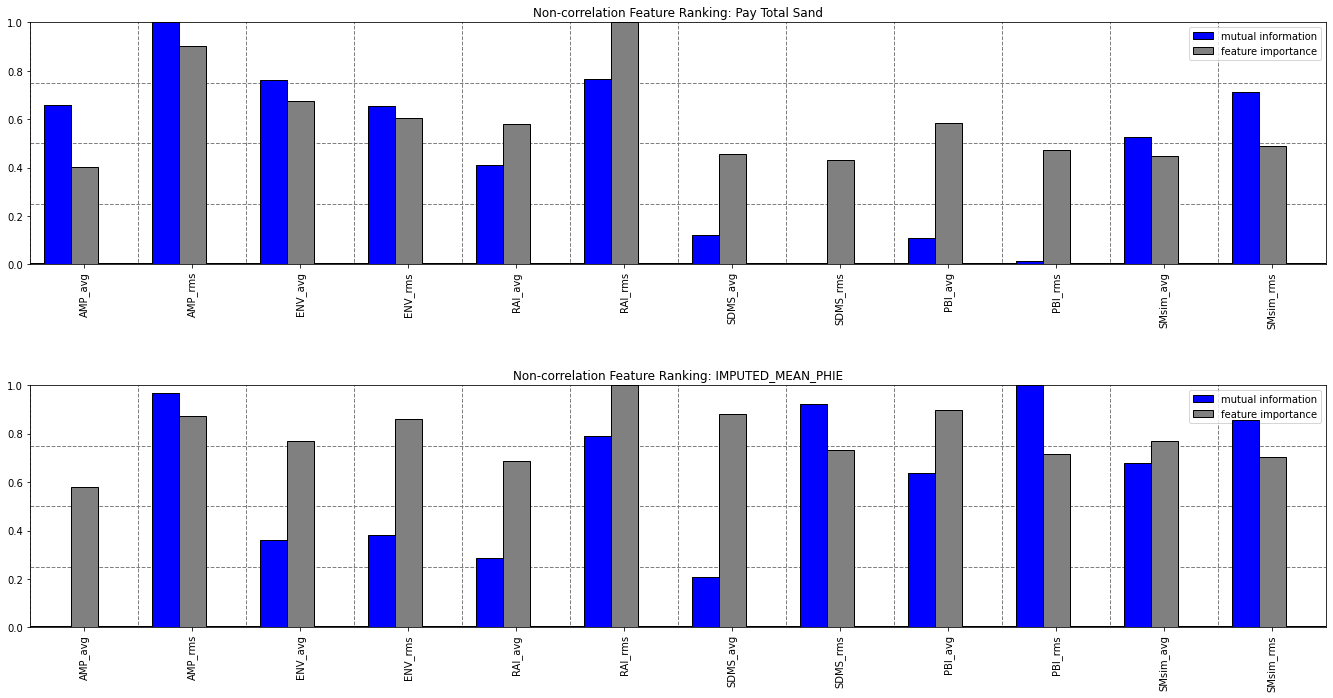

In [58]:
plt.subplot(211)                          # plot the relative mutual information 
plt.title("Non-correlation Feature Ranking: " + response)
#plt.plot([-0.5,14.5],[0.2,0.2],color='black',lw=2,ls='--',zorder=1)
#plt.fill_between([-0.5,14.5], [0.2,0.2], [0.0,0.0], color='grey',alpha=0.5,zorder=1)
plt.bar(np.arange(x.shape[1])-0.25, mi,width=0.25,
       color="blue",alpha=1.0,edgecolor='black',align="center",label='mutual information',zorder=100)
plt.bar(np.arange(x.shape[1])+0.0, importance_rank_stand,width=0.25,
       color="grey",alpha=1.0,edgecolor='black',align="center",label='feature importance',zorder=100)
plt.plot([-0.5,14.5],[0,0],color='black',lw=3)
plt.xticks(range(x.shape[1]), x.columns,rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([0,1])
for i in range(0,len(x.columns)):
    plt.plot([i-0.5,i-0.5],[-1,1],color='grey',lw=1,ls='--')
for i in np.arange(-1.0,1.0,0.25):
    plt.plot([-0.5,len(x.columns)+0.5],[i,i],color='grey',lw=1,ls='--')
plt.legend(loc='upper right')

plt.subplot(212)                          # plot the relative mutual information 
plt.title("Non-correlation Feature Ranking: " + response2)
#plt.fill_between([-0.5,14.5], [0.2,0.2], [0.0,0.0], color='grey',alpha=0.5,zorder=1)
plt.bar(np.arange(x.shape[1])-0.25, mi2,width=0.25,
       color="blue",alpha=1.0,edgecolor='black',align="center",label='mutual information',zorder=100)
plt.bar(np.arange(x.shape[1])+0.0, importance_rank_stand2,width=0.25,
       color="grey",alpha=1.0,edgecolor='black',align="center",label='feature importance',zorder=100)
plt.plot([-0.5,14.5],[0,0],color='black',lw=3)
plt.xticks(range(x.shape[1]), x.columns,rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([0,1])
for i in range(0,len(x.columns)):
    plt.plot([i-0.5,i-0.5],[-1,1],color='grey',lw=1,ls='--')
for i in np.arange(-1.0,1.0,0.25):
    plt.plot([-0.5,len(x.columns)+0.5],[i,i],color='grey',lw=1,ls='--')
plt.legend(loc='upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=2.1, wspace=0.2, hspace=0.5)
plt.show()

#### Partial Correlation Coefficient Ranking

Now let's calculate [Partial Correlation](https://youtu.be/5Q0gemu-h3Q?t=892) between the predictors and the response feature.

* a measure of correlation that removes the linear influence of the othe predictor features, accounts for linear redundancy
* we include rank correlation for comparison

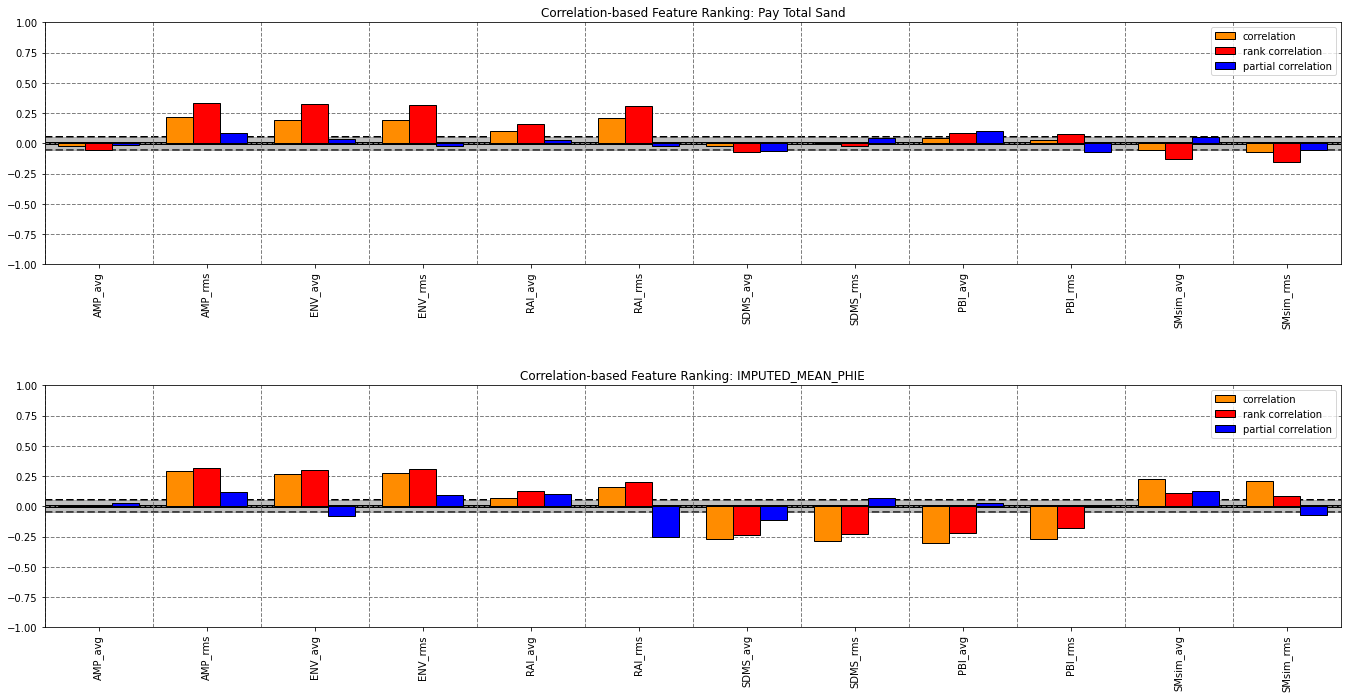

In [75]:
xncol = len(x.columns)
xy = x.copy(deep=True)
xy[response] = y
correlation = xy.iloc[:,:].corr().iloc[len(x.columns),:len(x.columns)]
rank_correlation, rank_correlation_pval = stats.spearmanr(xy.iloc[:,:])
rank_correlation = rank_correlation[:,len(x.columns)][:len(x.columns)]
rank_correlation_pval = rank_correlation_pval[:,len(x.columns)][:len(x.columns)]
partial_correlation = partial_corr(xy.iloc[:,:])
partial_correlation = partial_correlation[:,len(x.columns)][:len(x.columns)]

plt.subplot(211)                          # plot the relative mutual information 
plt.title("Correlation-based Feature Ranking: " + response)
plt.plot([-0.5,14.5],[0.05,0.05],color='black',lw=2,ls='--',zorder=1)
plt.plot([-0.5,14.5],[-0.05,-0.05],color='black',lw=2,ls='--',zorder=1)
plt.fill_between([-0.5,14.5], [0.05,0.05], [-0.05,-0.05], color='grey',alpha=0.5,zorder=1)
plt.bar(np.arange(x.shape[1])-0.25, correlation,width=0.25,
       color="darkorange",alpha=1.0,edgecolor='black',align="center",label='correlation',zorder=100)
plt.bar(np.arange(x.shape[1])+0.0, rank_correlation,width=0.25,
       color="red",alpha=1.0,edgecolor='black',align="center",label='rank correlation',zorder=100)
plt.bar(np.arange(x.shape[1])+0.25, partial_correlation,width=0.25,
       color="blue",alpha=1.0,edgecolor='black',align="center",label='partial correlation',zorder=100)
plt.plot([-0.5,14.5],[0,0],color='black',lw=3)
plt.xticks(range(x.shape[1]), x.columns,rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([-1,1])
for i in range(0,len(x.columns)):
    plt.plot([i-0.5,i-0.5],[-1,1],color='grey',lw=1,ls='--')
for i in np.arange(-1.0,1.0,0.25):
    plt.plot([-0.5,len(x.columns)+0.5],[i,i],color='grey',lw=1,ls='--')
plt.legend(loc='upper right')

xy2 = x.copy(deep=True)
xy2[response2] = y2
correlation2 = xy2.iloc[:,:].corr().iloc[len(x.columns),:len(x.columns)]
rank_correlation2, rank_correlation_pval2 = stats.spearmanr(xy2.iloc[:,:])
rank_correlation2 = rank_correlation2[:,len(x.columns)][:len(x.columns)]
rank_correlation_pval2 = rank_correlation_pval2[:,len(x.columns)][:len(x.columns)]
partial_correlation2 = partial_corr(xy2.iloc[:,:])
partial_correlation2 = partial_correlation2[:,len(x.columns)][:len(x.columns)]

plt.subplot(212)                          # plot the relative mutual information 
plt.title("Correlation-based Feature Ranking: " + response2)
plt.plot([-0.5,14.5],[0.05,0.05],color='black',lw=2,ls='--',zorder=1)
plt.plot([-0.5,14.5],[-0.05,-0.05],color='black',lw=2,ls='--',zorder=1)
plt.fill_between([-0.5,14.5], [0.05,0.05], [-0.05,-0.05], color='grey',alpha=0.5,zorder=1)
plt.bar(np.arange(x.shape[1])-0.25, correlation2,width=0.25,
       color="darkorange",alpha=1.0,edgecolor='black',align="center",label='correlation',zorder=100)
plt.bar(np.arange(x.shape[1])+0.0, rank_correlation2,width=0.25,
       color="red",alpha=1.0,edgecolor='black',align="center",label='rank correlation',zorder=100)
plt.bar(np.arange(x.shape[1])+0.25, partial_correlation2,width=0.25,
       color="blue",alpha=1.0,edgecolor='black',align="center",label='partial correlation',zorder=100)
plt.plot([-0.5,14.5],[0,0],color='black',lw=3)
plt.xticks(range(x.shape[1]), x.columns,rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([-1,1])
for i in range(0,len(x.columns)):
    plt.plot([i-0.5,i-0.5],[-1,1],color='grey',lw=1,ls='--')
for i in np.arange(-1.0,1.0,0.25):
    plt.plot([-0.5,len(x.columns)+0.5],[i,i],color='grey',lw=1,ls='--')
plt.legend(loc='upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=2.1, wspace=0.2, hspace=0.5)
plt.show()

#### Combine All Feature Ranking Metrics

Now let's combine all feature ranking metrics with significance.

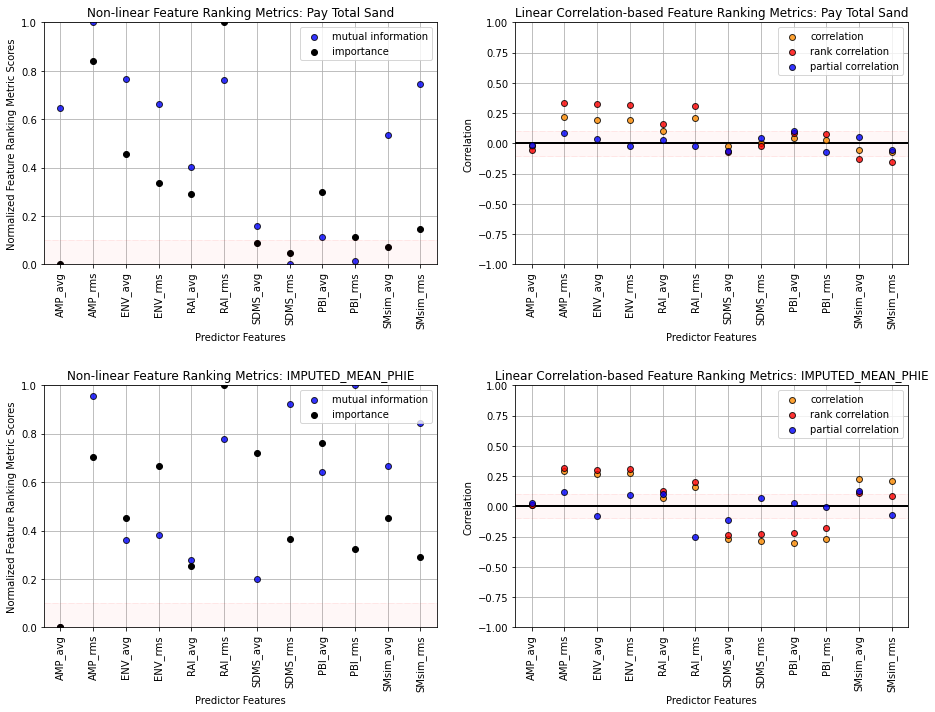

<Figure size 432x288 with 0 Axes>

In [76]:
buffer = 0.1
features = x.columns[:]
# Nrfe = (rfe_rank - np.min(rfe_rank))/(np.max(rfe_rank) - np.min(rfe_rank))
#Ncorrelation = (np.abs(correlation) - np.min(np.abs(correlation)))/(np.max(np.abs(correlation)) - np.min(np.abs(correlation)))
Ncorrelation = correlation

Nimportance = (importance_rank[:] - np.min(importance_rank[:]))/(np.max(np.abs(importance_rank[:])) - np.min(np.abs(importance_rank[:])))
Nmi = (mi[:] - np.min(mi[:]))/(np.max(mi[:]) - np.min(mi[:]))
#Npartial_correlation = (np.abs(partial_correlation) - np.min(np.abs(partial_correlation)))/(np.max(np.abs(partial_correlation)) - np.min(np.abs(partial_correlation)))
Npartial_correlation = partial_correlation

plt.subplot(221)
# plt.plot(features[:xncol-1],Nrfe,color='red',label='recursive feature')
plt.scatter(features[:],Nmi,color='blue',edgecolor='black',alpha = 0.8,label='mutual information')
plt.scatter(features[:],Nimportance,color='black',edgecolor='black',alpha=1.0,label='importance')

plt.plot([-0.5,len(features[:])],[buffer,buffer],dashes=[6, 2],color='red',linewidth = 1.0,alpha = 0.05)
plt.fill_between([-0.5,len(features[:])],[buffer,buffer],[0,0],color='red',alpha=0.03)

# plt.plot(np.full(len(features[:]),.1),dashes=[6, 2],color='red',linewidth = 1.0,alpha = 0.05)
# plt.fill_between(np.arange(0,len(features[:]),1), np.full(len(features[:]),0.0),np.full(len(features[:]),0.1),color='red',alpha=0.03)

#plt.plot(np.zeros(xncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Normalized Feature Ranking Metric Scores')
t = plt.title('Non-linear Feature Ranking Metrics: ' + response)
plt.ylim(0,1); plt.xlim([-0.5,len(features[:])-0.5])
plt.grid(True)
plt.legend(loc = 'upper right')

plt.subplot(222)
# plt.plot(features[:xncol-1],Nrfe,color='red',label='recursive feature')
plt.scatter(features[:],correlation,color='darkorange',edgecolor='black',alpha=0.8,label='correlation',zorder=100)
plt.scatter(features[:],rank_correlation,color='red',edgecolor='black',alpha=0.8,label='rank correlation',zorder=100)
plt.scatter(features[:],partial_correlation,color='blue',edgecolor='black',alpha = 0.8,label='partial correlation',zorder=100)
plt.plot([-0.5,len(features[:])+0.5],[0,0],color='black',linewidth = 2.0)
plt.plot([-0.5,len(features[:])+0.5],[buffer,buffer],dashes=[6, 2],color='red',linewidth = 1.0,alpha=0.05,zorder=1)
plt.plot([-0.5,len(features[:])+0.5],[-1*buffer,-1*buffer],dashes=[6, 2],color='red',linewidth = 1.0,alpha=0.05,zorder=1)
plt.fill_between([-0.5,len(features[:])+0.5],[-1*buffer,-1*buffer],[buffer,buffer],color='red',alpha=0.03,zorder=1)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Correlation')
t = plt.title('Linear Correlation-based Feature Ranking Metrics: ' + response)
plt.ylim(-1,1); plt.xlim([-0.5,len(features[:])-0.5])
plt.grid(True)
plt.legend(loc='upper right')


Ncorrelation2 = correlation2

Nimportance2 = (importance_rank2[:] - np.min(importance_rank2[:]))/(np.max(np.abs(importance_rank2[:])) - np.min(np.abs(importance_rank2[:])))
Nmi2 = (mi2[:] - np.min(mi2[:]))/(np.max(mi2[:]) - np.min(mi2[:]))
#Npartial_correlation = (np.abs(partial_correlation) - np.min(np.abs(partial_correlation)))/(np.max(np.abs(partial_correlation)) - np.min(np.abs(partial_correlation)))
Npartial_correlation2 = partial_correlation2

plt.subplot(223)
# plt.plot(features[:xncol-1],Nrfe,color='red',label='recursive feature')
plt.scatter(features[:],Nmi2,color='blue',edgecolor='black',alpha = 0.8,label='mutual information')
plt.scatter(features[:],Nimportance2,color='black',edgecolor='black',alpha=1.0,label='importance')

plt.plot([-0.5,len(features[:])],[buffer,buffer],dashes=[6, 2],color='red',linewidth = 1.0,alpha = 0.05)
plt.fill_between([-0.5,len(features[:])],[buffer,buffer],[0,0],color='red',alpha=0.03)

# plt.plot(np.full(len(features[:]),.1),dashes=[6, 2],color='red',linewidth = 1.0,alpha = 0.05)
# plt.fill_between(np.arange(0,len(features[:]),1), np.full(len(features[:]),0.0),np.full(len(features[:]),0.1),color='red',alpha=0.03)

#plt.plot(np.zeros(xncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Normalized Feature Ranking Metric Scores')
t = plt.title('Non-linear Feature Ranking Metrics: ' + response2)
plt.ylim(0,1); plt.xlim([-0.5,len(features[:])-0.5])
plt.grid(True)
plt.legend(loc = 'upper right')

plt.subplot(224)
# plt.plot(features[:xncol-1],Nrfe,color='red',label='recursive feature')
plt.scatter(features[:],correlation2,color='darkorange',edgecolor='black',alpha=0.8,label='correlation',zorder=100)
plt.scatter(features[:],rank_correlation2,color='red',edgecolor='black',alpha=0.8,label='rank correlation',zorder=100)
plt.scatter(features[:],partial_correlation2,color='blue',edgecolor='black',alpha = 0.8,label='partial correlation',zorder=100)
plt.plot([-0.5,len(features[:])+0.5],[0,0],color='black',linewidth = 2.0)
plt.plot([-0.5,len(features[:])+0.5],[buffer,buffer],dashes=[6, 2],color='red',linewidth = 1.0,alpha=0.05,zorder=1)
plt.plot([-0.5,len(features[:])+0.5],[-1*buffer,-1*buffer],dashes=[6, 2],color='red',linewidth = 1.0,alpha=0.05,zorder=1)
plt.fill_between([-0.5,len(features[:])+0.5],[-1*buffer,-1*buffer],[buffer,buffer],color='red',alpha=0.03,zorder=1)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Correlation')
t = plt.title('Linear Correlation-based Feature Ranking Metrics: ' + response2)
plt.ylim(-1,1); plt.xlim([-0.5,len(features[:])-0.5])
plt.grid(True)
plt.legend(loc='upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.5)
plt.show()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.5)
plt.show()

#### Compare Delta Mutual Information and Variance Inflation Factorabs

Both of these methods account for predictor feature redundancy

* VIF assumes linearity and does not account for relevance

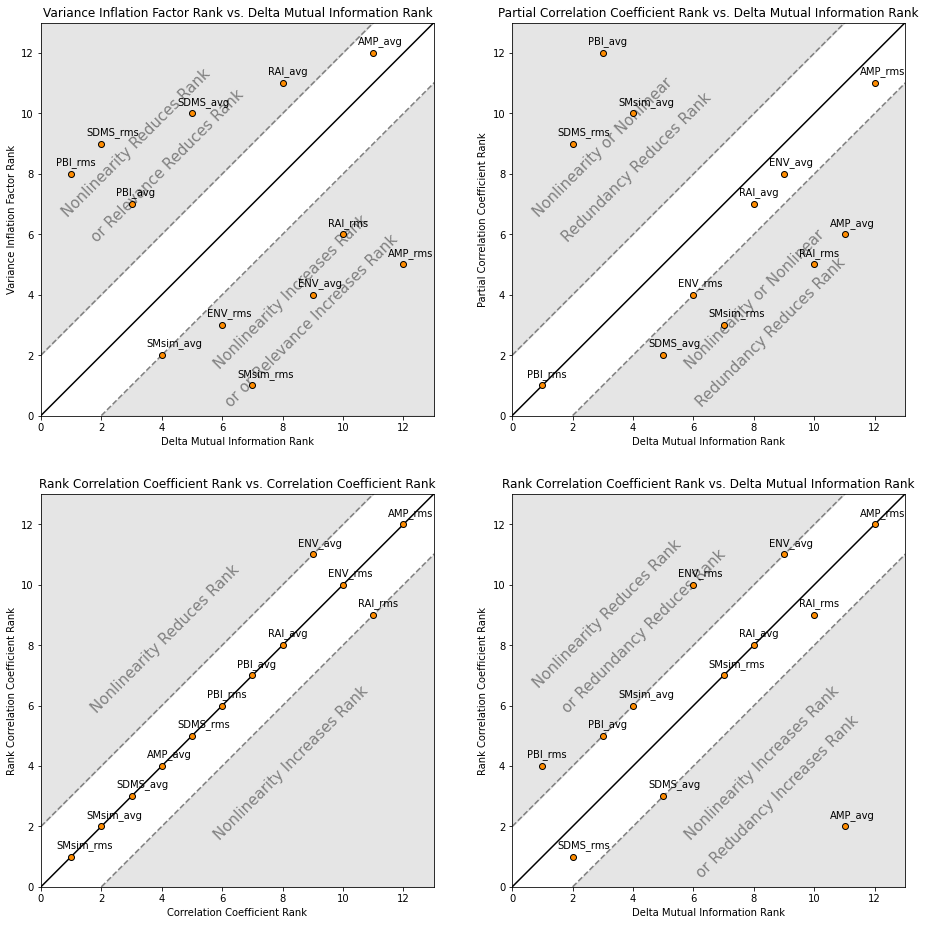

In [77]:
buffer = 2

plt.subplot(221)
ranking_comparison(features,stats.rankdata(delta_mutual_information),'Delta Mutual Information',
                    stats.rankdata(-vif_values),'Variance Inflation Factor',
                   'Nonlinearity Reduces Rank','or Relevance Reduces Rank',
                   'Nonlinearity Increases Rank','or or Relevance Increases Rank',4.0)  

plt.subplot(222)
ranking_comparison(features,stats.rankdata(delta_mutual_information),'Delta Mutual Information',
                    stats.rankdata(partial_correlation),'Partial Correlation Coefficient',
                   'Nonlinearity or Nonlinear','Redundancy Reduces Rank',
                   'Nonlinearity or Nonlinear','Redundancy Reduces Rank',4.0)

plt.subplot(223)
ranking_comparison(features,stats.rankdata(correlation),'Correlation Coefficient',
                    stats.rankdata(rank_correlation),'Rank Correlation Coefficient',
                   '','Nonlinearity Reduces Rank',
                   'Nonlinearity Increases Rank','',4.0)

plt.subplot(224)
ranking_comparison(features,stats.rankdata(delta_mutual_information),'Delta Mutual Information',
                    stats.rankdata(np.abs(rank_correlation)),'Rank Correlation Coefficient',
                   'Nonlinearity Reduces Rank','or Redundancy Reduces Rank',
                   'Nonlinearity Increases Rank','or Redudancy Increases Rank',4.0)  

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.0, wspace=0.2, hspace=0.2); plt.show()

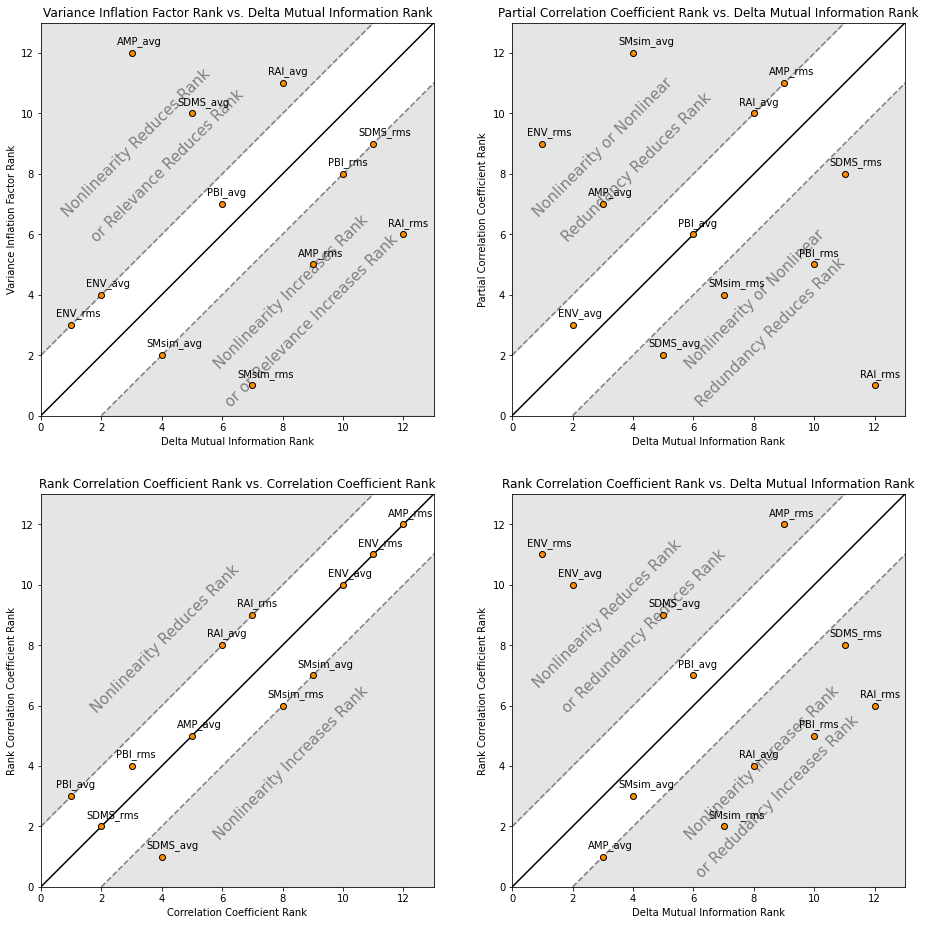

In [78]:
buffer = 2

plt.subplot(221)
ranking_comparison(features,stats.rankdata(delta_mutual_information2),'Delta Mutual Information',
                    stats.rankdata(-vif_values),'Variance Inflation Factor',
                   'Nonlinearity Reduces Rank','or Relevance Reduces Rank',
                   'Nonlinearity Increases Rank','or or Relevance Increases Rank',4.0)  

plt.subplot(222)
ranking_comparison(features,stats.rankdata(delta_mutual_information2),'Delta Mutual Information',
                    stats.rankdata(partial_correlation2),'Partial Correlation Coefficient',
                   'Nonlinearity or Nonlinear','Redundancy Reduces Rank',
                   'Nonlinearity or Nonlinear','Redundancy Reduces Rank',4.0)

plt.subplot(223)
ranking_comparison(features,stats.rankdata(correlation2),'Correlation Coefficient',
                    stats.rankdata(rank_correlation2),'Rank Correlation Coefficient',
                   '','Nonlinearity Reduces Rank',
                   'Nonlinearity Increases Rank','',4.0)

plt.subplot(224)
ranking_comparison(features,stats.rankdata(delta_mutual_information2),'Delta Mutual Information',
                    stats.rankdata(np.abs(rank_correlation2)),'Rank Correlation Coefficient',
                   'Nonlinearity Reduces Rank','or Redundancy Reduces Rank',
                   'Nonlinearity Increases Rank','or Redudancy Increases Rank',4.0)  

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.0, wspace=0.2, hspace=0.2); plt.show()

List the available predictor features.

In [85]:
print('Available Features')
for i in range(0,len(x.columns)):
    print(i,x.columns[i])

Available Features
0 AMP_avg
1 AMP_rms
2 ENV_avg
3 ENV_rms
4 RAI_avg
5 RAI_rms
6 SDMS_avg
7 SDMS_rms
8 PBI_avg
9 PBI_rms
10 SMsim_avg
11 SMsim_rms


#### For Simple Demonstration Use the Top Predictor Features to Build a Simple Model

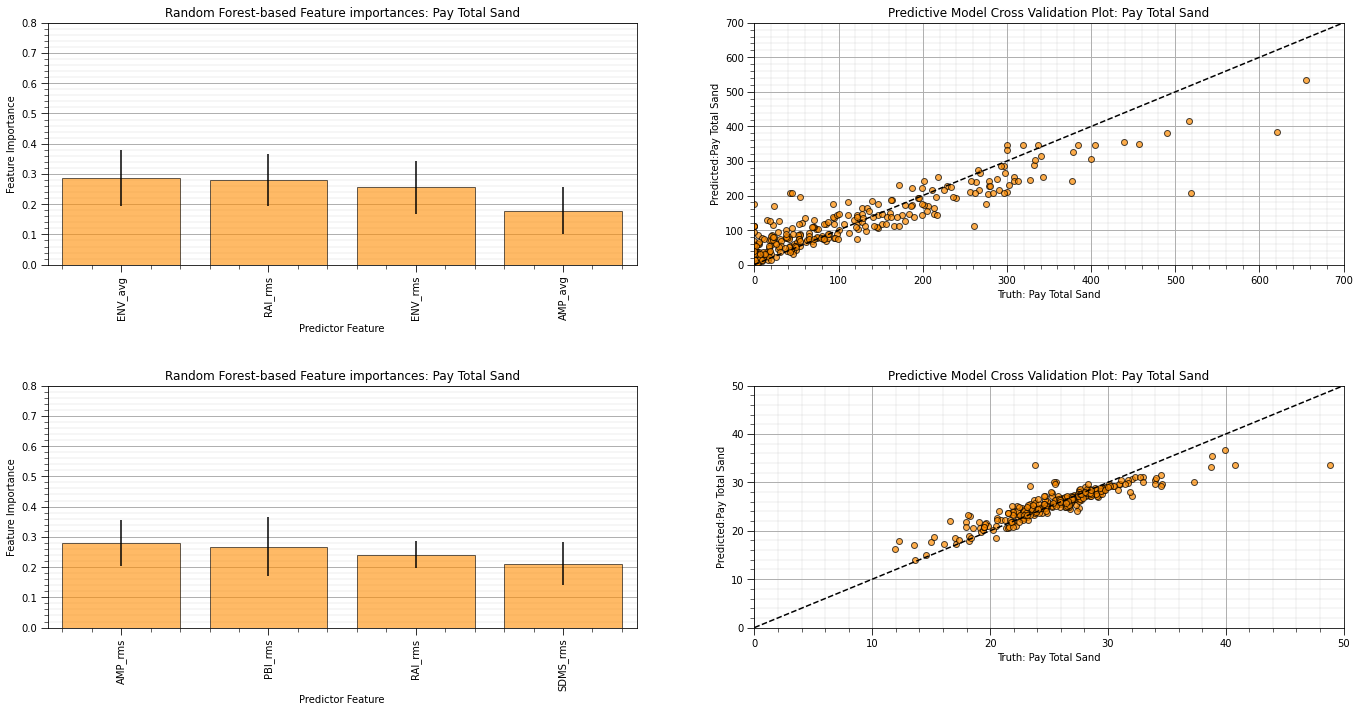

In [136]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
selected_features = np.r_[5,2,3,0]
x_selected = x.iloc[:,selected_features]

seed = 73093                                                # set the random forest hyperparameters
max_depth = 20
num_tree = 30
max_features = 2
random_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)

#random_forest = RandomForestRegressor(min_samples_leaf = 2,max_features = 2,max_leaf_nodes = 10)               # instantiate the random forest  
random_forest = random_forest.fit(x_selected,y) # fit the random forest
y_hat = random_forest.predict(x_selected)
importance_rank = random_forest.feature_importances_ # extract the expected feature importances

importance_rank_stand = importance_rank/np.max(importance_rank)                          # calculate relative mutual information

std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importance_rank)[::-1]           # find indicies for descending order

plt.subplot(221)                                      # plot the feature importance 
plt.title("Random Forest-based Feature importances: " + response)
plt.bar(range(x_selected.shape[1]), importance_rank[indices],edgecolor = 'black',
       color="darkorange",alpha = 0.6, yerr=std[indices], align="center")
plt.xticks(range(x_selected.shape[1]), x_selected.columns[indices],rotation=90)
plt.xlim([-0.5, x_selected.shape[1]-0.5]); 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.ylim([0.,0.8])
plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplot(222)
plt.scatter(y,y_hat,color='darkorange',edgecolor='black',alpha=0.7)
plt.grid(b=True,which='both',axis='both')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.xlim([0,700]); plt.ylim([0,700]); plt.xlabel('Truth: ' + response); plt.ylabel('Predicted:' + response)
plt.plot([0,700],[0,700],color='black',ls='--'); plt.title('Predictive Model Cross Validation Plot: ' + response)



selected_features2 = np.r_[1,5,7,9]
x_selected2 = x.iloc[:,selected_features2]

seed2 = 73093                                                # set the random forest hyperparameters
max_depth2 = 20
num_tree2 = 30
max_features2 = 2
random_forest2 = RandomForestRegressor(max_depth=max_depth2, random_state=seed2,n_estimators=num_tree2, max_features=max_features2)

#random_forest = RandomForestRegressor(min_samples_leaf = 2,max_features = 2,max_leaf_nodes = 10)               # instantiate the random forest  
random_forest2 = random_forest2.fit(x_selected2,y2) # fit the random forest
y_hat2 = random_forest2.predict(x_selected2)
importance_rank2 = random_forest2.feature_importances_ # extract the expected feature importances

importance_rank_stand2 = importance_rank2/np.max(importance_rank2)                          # calculate relative mutual information

std2 = np.std([tree.feature_importances_ for tree in random_forest2.estimators_],axis=0) # calculate stdev over trees
indices2 = np.argsort(importance_rank2)[::-1]           # find indicies for descending order

plt.subplot(223)                                      # plot the feature importance 
plt.title("Random Forest-based Feature importances: " + response)
plt.bar(range(x_selected2.shape[1]), importance_rank2[indices2],edgecolor = 'black',
       color="darkorange",alpha = 0.6, yerr=std2[indices2], align="center")
plt.xticks(range(x_selected2.shape[1]), x_selected2.columns[indices2],rotation=90)
plt.xlim([-0.5, x_selected2.shape[1]-0.5]); 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.ylim([0.,0.8])
plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplot(224)
plt.scatter(y2,y_hat2,color='darkorange',edgecolor='black',alpha=0.7)
plt.grid(b=True,which='both',axis='both')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.xlim([0,50]); plt.ylim([0,50]); plt.xlabel('Truth: ' + response); plt.ylabel('Predicted:' + response)
plt.plot([0,50],[0,50],color='black',ls='--'); plt.title('Predictive Model Cross Validation Plot: ' + response)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=2.1, wspace=0.2, hspace=0.5); plt.show()

#### Summarize All Bivariate Metrics 

Let's use heat maps to summarize all the feature pairwise metrics. We calculate the differences to aid in interpretation.

* **partial correlation - correlation** - impact of confounding features on correlation
* **mutual information - correlation** - impact of nonlinearity and heteroscedasticity

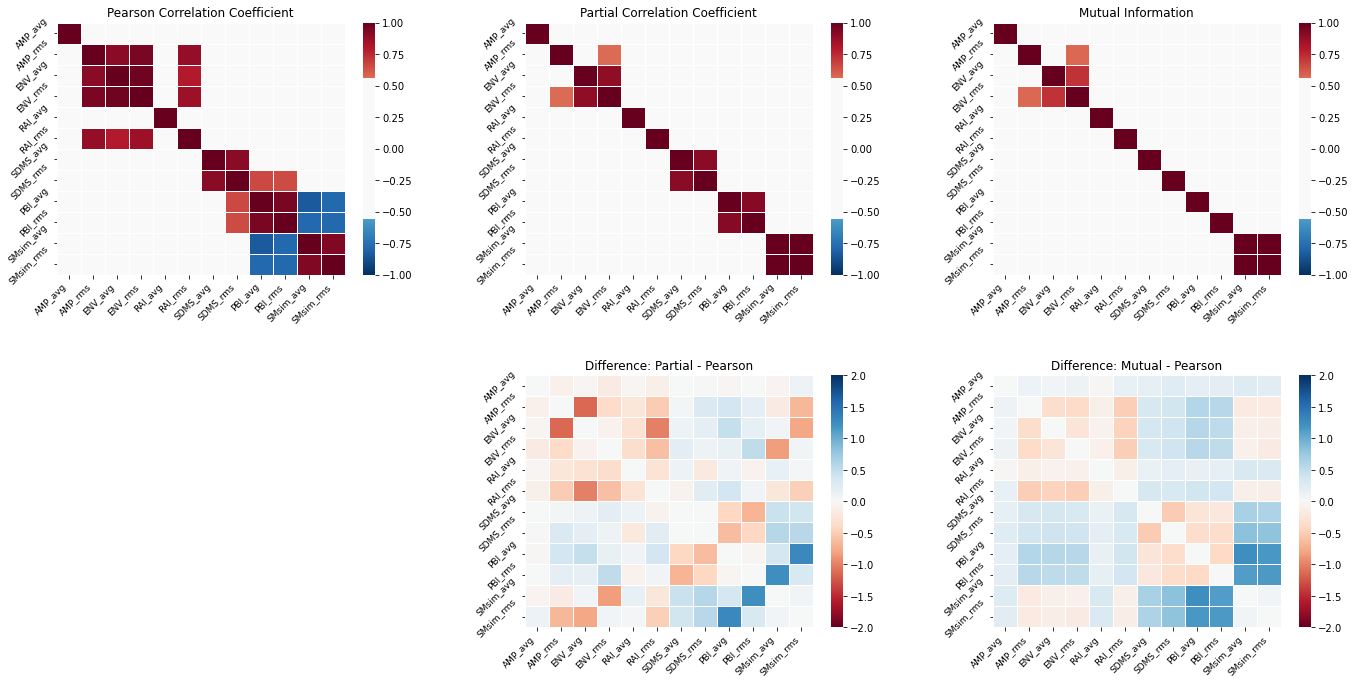

In [33]:
nsample = -1
if nsample > 0:
    df_sample = df.sample(n=nsample)
else: 
    df_sample = df
    
plt.subplot(231)                          # plot a color coded correlation matrix
df_corr = df_sample[features].corr()
sns.heatmap(df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.xticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.yticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')

plt.title('Pearson Correlation Coefficient')

plt.subplot(232)                          # plot a color coded correlation matrix
partial_correlation = partial_corr(df_nonull[features]) # calculate the partial correlation coefficients
df_partial = pd.DataFrame(partial_correlation,columns=features,index=features)
sns.heatmap(df_partial,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.xticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.yticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.title('Partial Correlation Coefficient')

plt.subplot(233)
df_mutual = pd.DataFrame(mutual_matrix(df_nonull[features],features),columns=features,index=features)
sns.heatmap(df_mutual,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)  
plt.xticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.yticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.title('Mutual Information')

plt.subplot(235)
sns.heatmap(df_partial-df_corr,vmin = -2.0, vmax = 2.0,linewidths=.5, fmt= '.1f',cmap = plt.cm.RdBu) 
plt.xticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.yticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.title('Difference: Partial - Pearson')

plt.subplot(236)
plot = sns.heatmap(df_mutual-df_corr,vmin = -2.0, vmax = 2.0,linewidths=.5, fmt= '.1f',cmap = plt.cm.RdBu) 
plt.xticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')
plt.yticks(np.arange(len(features))+0.5,features, color='black', rotation=45, fontsize='9', horizontalalignment='right')

plt.title('Difference: Mutual - Pearson')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.3, hspace=0.4)
plt.show()

#### Specify the Map 2D Grid

In [88]:
xmin = 80000; xmax = 800000
ymin = 3000000; ymax = 3300000

nx = 144; ny = 60

xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
xmn = xmin + xsiz*0.5; ymn = ymin + ysiz*0.5

xx, yy = np.meshgrid(np.arange(xmn, xmax, xsiz), np.arange(ymax-ysiz*0.5, ymin, -1 * ysiz))

print('nx: ' + str(nx) + ' , xmn: ' + str(xmn) + ' , xsiz: ' + str(xsiz))
print('ny: ' + str(ny) + ' , ymn: ' + str(ymn) + ' , ysiz: ' + str(ysiz))
print('Total number of cells: ' + str(nx*ny))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ' = ' + str(xmax-xmin) + ', extents y: ' + str(ymin) + ' - ' + str(ymax) + ' = ' + str(ymax-ymin))

ref = 4
rnx = nx*ref; rny = ny*ref
rxsiz = xsiz/ref; rysiz = ysiz/ref
rxmn = xmin + rxsiz/2; rymn = ymin + rysiz/2
rxmin = xmin; rxmax = rxmin + rnx*rxsiz; rymin = ymin; rymax = rymin + rny*rysiz

print('Refined nx: ' + str(rnx) + ' , xmn: ' + str(rxmn) + ' , xsiz: ' + str(rxsiz))
print('Refined ny: ' + str(rny) + ' , ymn: ' + str(rymn) + ' , ysiz: ' + str(rysiz))
print('Total number of refined cells: ' + str(rnx*rny))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ' = ' + str(xmax-xmin) + ', extents y: ' + str(ymin) + ' - ' + str(ymax) + ' = ' + str(ymax-ymin))


nx: 144 , xmn: 82500.0 , xsiz: 5000.0
ny: 60 , ymn: 3002500.0 , ysiz: 5000.0
Total number of cells: 8640
extents x: 80000 - 800000 = 720000, extents y: 3000000 - 3300000 = 300000
Refined nx: 576 , xmn: 80625.0 , xsiz: 1250.0
Refined ny: 240 , ymn: 3000625.0 , ysiz: 1250.0
Total number of refined cells: 138240
extents x: 80000 - 800000 = 720000, extents y: 3000000 - 3300000 = 300000


In [101]:
x_selected

,RAI_rms,ENV_avg,ENV_rms,AMP_avg
0,0.801342,0.620927,0.692911,0.001247
1,1.238200,0.808946,0.955027,-0.001618
2,0.740130,0.387977,0.443267,-0.003547
3,0.651137,0.419338,0.487525,-0.000958
4,1.314789,0.883893,1.021655,-0.000816
5,1.291535,0.830516,0.936981,0.004262
6,1.136316,0.578657,0.663699,-0.002595
7,1.399983,0.979875,1.099418,0.000411
8,0.994655,0.422940,0.478735,0.000386
9,1.311210,0.564719,0.662892,0.001050


#### Load the Kriged Maps and Build ML Prediction Model

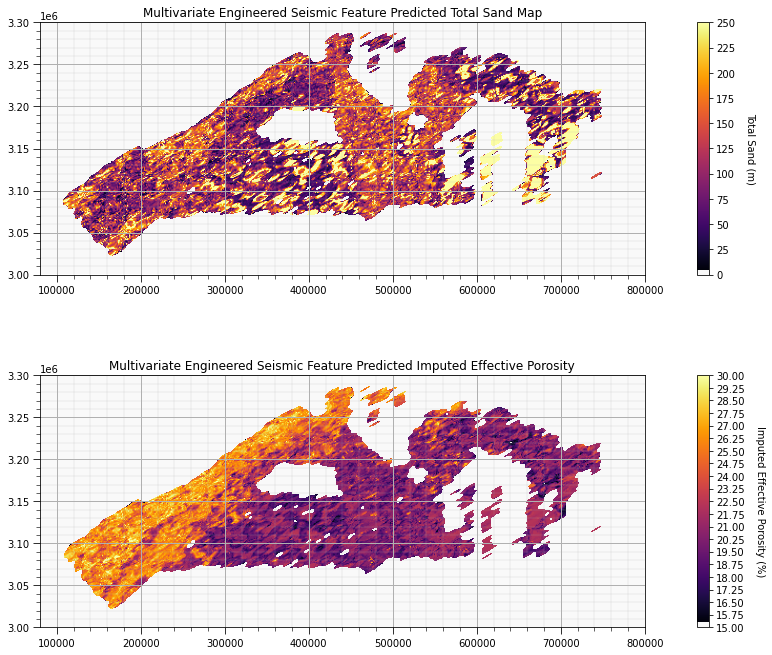

In [143]:
model_features = x_selected.columns

skest_mat = np.zeros((len(model_features),rny,rnx)); skvar_mat = np.zeros((len(model_features),rny,rnx))
skest_flat = np.zeros((len(model_features),rny*rnx)); skvar_flat = np.zeros((len(model_features),rny*rnx))


for i, feature in enumerate(model_features):
    skest_mat[i] = np.loadtxt(model_features[i] + '_skest.csv', delimiter=",")
    skvar_mat[i] = np.loadtxt(model_features[i] + '_skvar.csv', delimiter=",")
    

for i, feature in enumerate(model_features):
    skest_flat[i] = skest_mat[i].flatten()
    skvar_flat[i] = skvar_mat[i].flatten()

y_flat = random_forest.predict(skest_flat.T)
y_mat = np.reshape(y_flat,(rny,rnx))    
y_mat[skvar_mat[0] > np.max(skvar_flat[0])*0.8] = -999.9
    
# y_hat = random_forest.predict(x)

plt.subplot(211)
sc1 = plt.imshow(y_mat,vmin = 0, vmax = 250,extent = [rxmin,rxmax,rymin,rymax],cmap = mask_inferno,interpolation=None)

#plt.xlim([rxmin,rxmax]); plt.ylim([rymin,rymax])
cbar = plt.colorbar(sc1, orientation="vertical",ticks=np.linspace(0,500,21),fraction=0.046, pad=0.04)
cbar.set_label('Total Sand (m)', rotation=270, labelpad=20)
plt.title('Multivariate Engineered Seismic Feature Predicted Total Sand Map')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)

model_features2 = x_selected2.columns

skest_mat2 = np.zeros((len(model_features2),rny,rnx)); skvar_mat2 = np.zeros((len(model_features2),rny,rnx))
skest_flat2 = np.zeros((len(model_features2),rny*rnx)); skvar_flat2 = np.zeros((len(model_features2),rny*rnx))

for i, feature in enumerate(model_features2):
    skest_mat2[i] = np.loadtxt(model_features2[i] + '_skest.csv', delimiter=",")
    skvar_mat2[i] = np.loadtxt(model_features2[i] + '_skvar.csv', delimiter=",")
    

for i, feature in enumerate(model_features2):
    skest_flat2[i] = skest_mat2[i].flatten()
    skvar_flat2[i] = skvar_mat2[i].flatten()

y_flat2 = random_forest2.predict(skest_flat2.T)
y_mat2 = np.reshape(y_flat2,(rny,rnx))    
y_mat2[skvar_mat2[0] > np.max(skvar_flat2[0])*0.8] = -999.9
    
# y_hat = random_forest.predict(x)

plt.subplot(212)
sc1 = plt.imshow(y_mat2,vmin = 15, vmax = 30,extent = [rxmin,rxmax,rymin,rymax],cmap = mask_inferno,interpolation=None)

#plt.xlim([rxmin,rxmax]); plt.ylim([rymin,rymax])
cbar = plt.colorbar(sc1, orientation="vertical",ticks=np.linspace(15,30,21),fraction=0.046, pad=0.04)
cbar.set_label('Imputed Effective Porosity (%)', rotation=270, labelpad=20)
plt.title('Multivariate Engineered Seismic Feature Predicted Imputed Effective Porosity')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.3, hspace=0.4); plt.show()

#### Model Summary Statistics

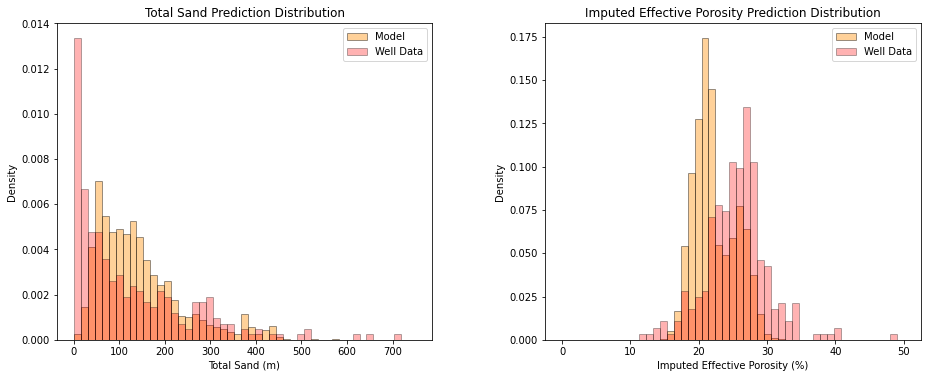

In [164]:
plt.subplot(121)
plt.hist(y_flat,bins = np.linspace(0,750,50),facecolor='darkorange',alpha=0.4,edgecolor='black',density=True,label = 'Model')
plt.hist(y,bins = np.linspace(0,750,50),facecolor='red',alpha=0.3,edgecolor='black',density=True,label = 'Well Data')
plt.xlabel('Total Sand (m)'); plt.ylabel('Density'); plt.title('Total Sand Prediction Distribution')
plt.legend(loc='upper right')

plt.subplot(122)
plt.hist(y_flat2,bins = np.linspace(0,50,50),facecolor='darkorange',alpha=0.4,edgecolor='black',density=True,label = 'Model')
plt.hist(y2,bins = np.linspace(0,50,50),facecolor='red',alpha=0.3,edgecolor='black',density=True,label = 'Well Data')
plt.xlabel('Imputed Effective Porosity (%)'); plt.ylabel('Density'); plt.title('Imputed Effective Porosity Prediction Distribution')
plt.legend(loc='upper right')


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.3, hspace=0.4); plt.show()

#### Write out Prediction Model

In [144]:
xmat = []; ymat = []; predmat = []; predmat2 = []

for iy in range(0,rny):
    ycoord = rymn + (rny-iy-1) * rysiz # y origin is at the top
    for ix in range(0,rnx):
        xcoord = rxmn + ix * rxsiz
        if y_mat[iy,ix] > -99 and y_mat[iy,ix] < 400:
            xmat.append(xcoord)
            ymat.append(ycoord)
            predmat.append(y_mat[iy,ix])
            predmat2.append(y_mat2[iy,ix])

pd.options.display.float_format = '{:.2f}'.format
df_pred = pd.DataFrame({'x':xmat,'y':ymat,'Total Sand (m)':predmat,'Imputed Effective Porosity (%)':predmat2})
df_pred.head()
df_pred.describe().transpose()

df_pred.to_csv('Pred_TotalSand_PHIE_MioceneCCUS.csv',index=False,float_format = '%.2f')

#### References

Gulgezen, G., Cataltepe, Z., Yu, L., 2009, Stable and Accurate Feature Selection. In: Buntine, W., Grobelnik, M., Mladenić, D., Shawe-Taylor, J. (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD 2009. Lecture Notes in Computer Science(), vol 5781. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-04180-8_47.

Henze, N., & Zirkler, B. (1990). A class of invariant consistent tests for multivariate normality. Communications in Statistics-Theory and Methods, 19(10), 3595-3617.

Trujillo-Ortiz, A., R. Hernandez-Walls, K. Barba-Rojo and L. Cupul-Magana. (2007). HZmvntest: Henze-Zirkler’s Multivariate Normality Test. A MATLAB file.

Pyrcz, M.J., Jo. H., Kupenko, A., Liu, W., Gigliotti, A.E., Salomaki, T., and Santos, J., 2021, GeostatsPy Python Package, PyPI, Python Package Index, https://pypi.org/project/geostatspy/.

#### Comments

This was a simple demonstration of feature selection. This workflow is for educational purposes only, all results must be checked.

I have many other demonstrations on data analytics and machine learning, e.g. on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)